In [11]:
import os
import sys

# Define SUMO_HOME (standard path after apt-get install)
SUMO_HOME = "/usr/share/sumo"
os.environ["SUMO_HOME"] = SUMO_HOME
sys.path.append(os.path.join(SUMO_HOME, 'tools'))

print(f"SUMO_HOME is set to: {SUMO_HOME}")


SUMO_HOME is set to: /usr/share/sumo


In [11]:
import traci
traci.close()

BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# below is v3

--- Starting A2C Traffic Control (v3) ---
Model loaded successfully from v3_a2c_checkpoint.pth
Starting SUMO: /usr/share/sumo/bin/sumo -c _1.sumocfg --step-length 1 --remote-port 8813 --no-step-log --start
TraCI Connected.

--- EPISODE 1/600 ---
Training Interrupted: name 'new_state' is not defined

Generating Plots...


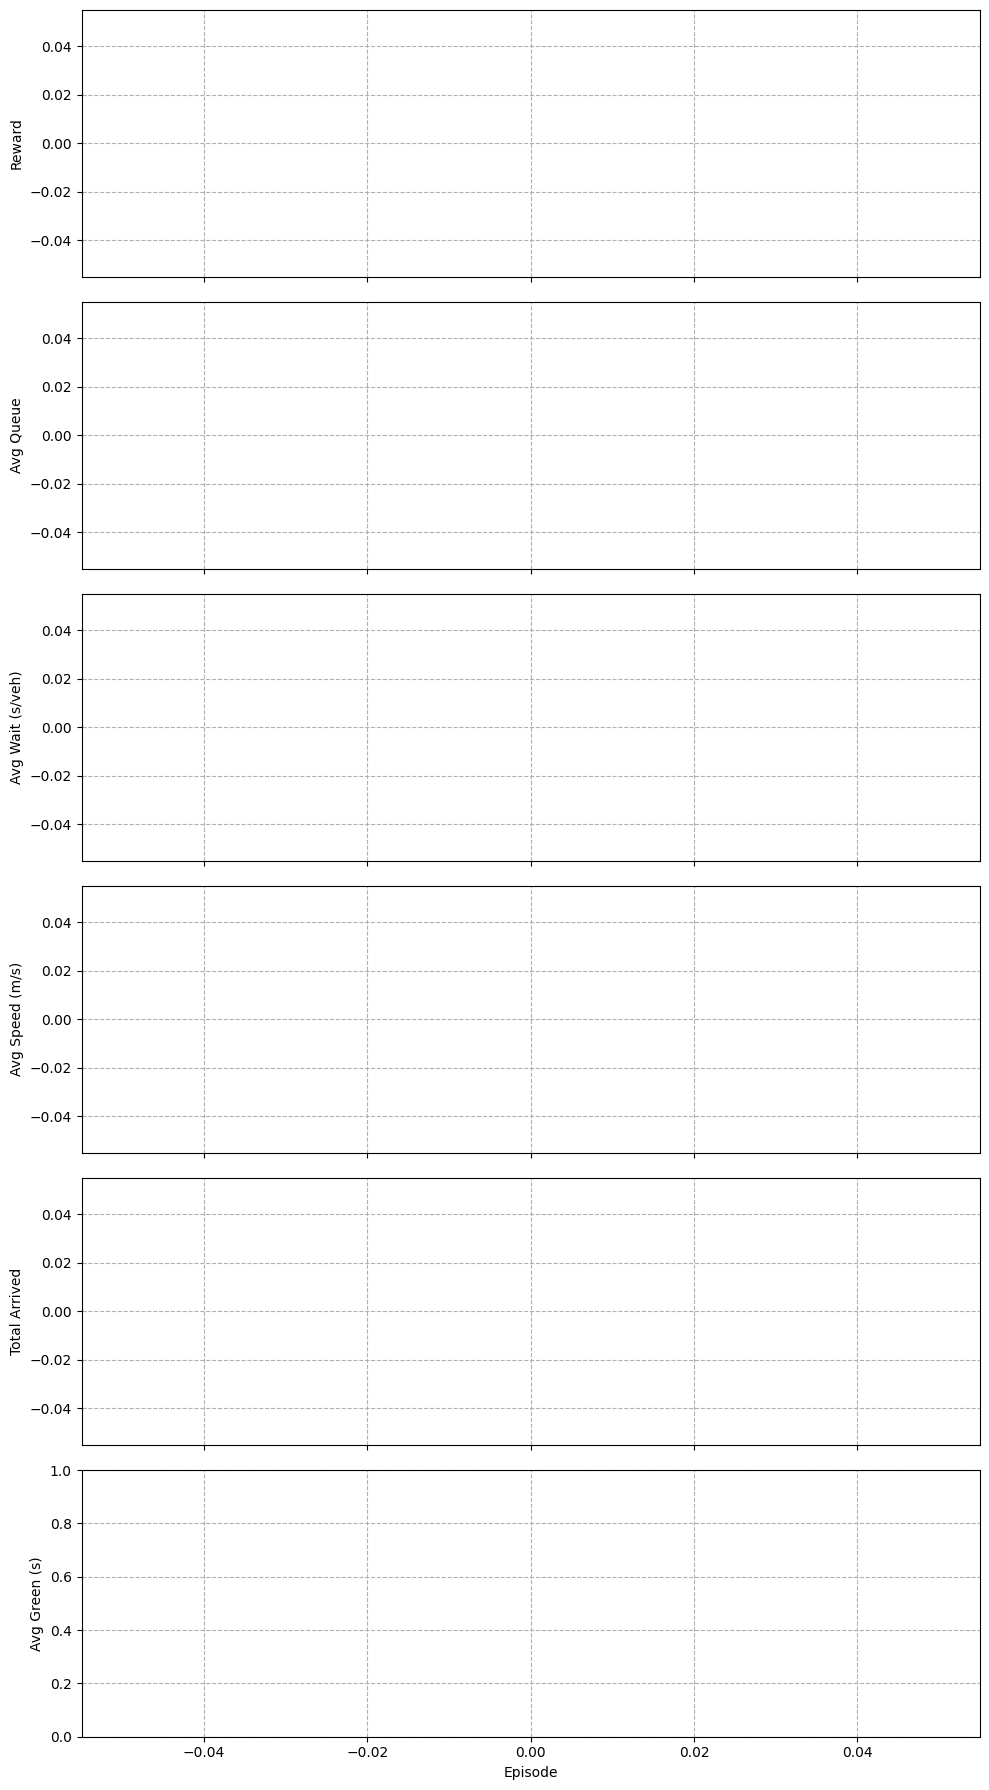

In [3]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt

# ==============================================================================
# 1. HYPERPARAMETERS AND CONSTANTS (UPDATED v3)
# ==============================================================================
# --- A2C Hyperparameters ---
STATE_DIM = 32
PHASE_DIM = 4
HIDDEN_1 = 128
HIDDEN_2 = 64
ACTION_CONTINUOUS_DIM = 1

# Output Limits
MIN_DURATION = 10.0 
MAX_DURATION = 60.0 

# Training Hyperparameters
LR = 1e-3              # Higher learning rate for normalized inputs
GAMMA = 0.95           # Focus on immediate traffic clearing
ENTROPY_BETA = 0.05    # Higher entropy to prevent "Phase 1" mode collapse
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v3_a2c_checkpoint.pth"  # <--- UPDATED CHECKPOINT NAME

# --- Reward Weights (SCALED DOWN & NORMALIZED) ---
REWARD_WEIGHT_WAIT_TIME = 0.05   # Reduced to prevent -900k rewards
REWARD_WEIGHT_MAX_WAIT = 0.1     
REWARD_WEIGHT_DURATION = 0.5     
REWARD_WEIGHT_QUEUE_DIFF = 0.2   
BUMPER_REWARD_BONUS = 2.0        
BUMPER_THRESHOLD = 2

# --- Normalization Factors (NEW) ---
NORM_MAX_QUEUE = 20.0  # Approx max cars per lane
NORM_MAX_WAIT = 100.0  # Soft cap for normalizing wait times
NORM_MAX_SPEED = 15.0  # Approx max speed (m/s)

# --- Simulation Configuration ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 800


# --- Environment Parameters ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},  # Phase 0: N/S Straight
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},  # Phase 1: E/W Straight
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},  # Phase 2: N/S Left Turns
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"}   # Phase 3: E/W Left Turns
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None


# ==============================================================================
# 2. ACTOR-CRITIC NETWORK
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        
        # Shared Backbone
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )

        # Heads
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        
        return phase_logits, mu, log_std, value


# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE

        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION

        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)

        # Discrete
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)

        # Continuous
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        
        # Clip
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()

        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)

        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    # --- UPDATED: N-Step Bootstrapping and Continuous Entropy ---
    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']:
            return 0.0

        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']

        # Calculate Returns with Bootstrapping
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d:
                R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)

        Advantage = returns - values
        
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()

        # Entropy Calculation (Discrete + Continuous)
        phase_logits, mu, log_std, _ = self.net(states)
        
        # Discrete Entropy
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        
        # Continuous Entropy
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()

        total_entropy = phase_entropy + duration_entropy
        
        # Total Loss
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * total_entropy

        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()

        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        try:
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Model loaded successfully from {self.checkpoint_path}")
        except FileNotFoundError:
            print("Checkpoint file not found. Starting training from scratch.")
        except Exception as e:
            print(f"Error loading model: {e}. Starting training from scratch.")


# ==============================================================================
# 4. TRAFFIC AGENT (SUMO Interface)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string,
                 min_green_time=10, yellow_time=2, all_red_time=1):
        
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string

        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time

        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        self.time_in_current_phase = 0
        self.next_phase_index = 0

        # Metrics
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)

        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except traci.TraCIException as e:
            pass

    def get_state(self):
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)

        waiting_times = []
        for lane_id in self.incoming_lanes:
            try:
                w = traci.lane.getWaitingTime(lane_id)
            except:
                w = 0
            waiting_times.append(w)

        # --- NORMALIZATION (KEY FIX) ---
        # Normalize raw values to approx 0-1 range for the Neural Net
        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN":
            self.phase_one_hot[self.current_phase_index] = 1.0

        state = np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])
        return state

    def get_reward(self, chosen_duration):
        # 1. Wait Penalty (Scaled)
        r_wait_penalty = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)

        # 2. Max Wait Penalty (Scaled)
        r_max_wait_penalty = -REWARD_WEIGHT_MAX_WAIT * np.max(self.current_waiting_times)

        # 3. Queue Reduction Reward 
        # Note: We need to use un-normalized queue lengths for the difference calculation to mean anything physically
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)

        # 4. Bumper Bonus
        r_bumper = BUMPER_REWARD_BONUS if Q_t_plus_1 < BUMPER_THRESHOLD else 0.0

        # 5. Duration Bonus
        duration_norm = (chosen_duration - MIN_DURATION) / (MAX_DURATION - MIN_DURATION)
        r_duration = duration_norm * REWARD_WEIGHT_DURATION

        return r_wait_penalty + r_max_wait_penalty + r_queue_diff + r_bumper + r_duration

    def step(self, action):
        next_green_phase_index, green_duration = action
        
        # Store UN-NORMALIZED queue lengths for next reward calculation
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        
        try:
            # Yellow
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): traci.simulationStep()
            
            # All Red
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): traci.simulationStep()
            
            # Green
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            
            for _ in range(green_duration): traci.simulationStep()
            
        except traci.TraCIException:
            pass

        new_state = self.get_state()
        reward = self.get_reward(green_duration)
        return new_state, reward, False, {}

    def get_episode_metrics(self):
        # We fetch raw data from SUMO again because "self.current_queue_lengths" is now normalized
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except:
            total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0

        return {
            'total_halting': total_halting,
            'total_wait_sec': total_waiting,
            'avg_speed': avg_spd,
            'throughput_step': throughput,
            'arrived_in_step': arrived_in_step 
        }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0:
                avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)


# ==============================================================================
# 5. SUMO CONTROL UTILS
# ==============================================================================
def stop_sumo():
    global global_sumo_process
    
    # 1. Try to close TraCI connection gracefully
    try:
        traci.close()
    except (traci.FatalTraCIError, BrokenPipeError, ConnectionRefusedError):
        # If the connection is already dead, just ignore it
        pass
    except Exception as e:
        # Catch any other weirdness but print it so we know
        print(f"Note: TraCI close ignored: {e}")

    # 2. Force kill the SUMO process if it's still hanging around
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired:
            global_sumo_process.kill() # Force kill if it won't terminate
        except Exception:
            pass
        finally:
            global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)

    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False

    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", "8813", "--no-step-log", "--start"]
    
    print(f"Starting SUMO: {' '.join(cmd)}")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(1)

    for i in range(10):
        try:
            traci.init(8813)
            print("TraCI Connected.")
            return True
        except traci.exceptions.TraCIException:
            time.sleep(1)
    
    print("TraCI Connection Failed.")
    return False


# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    # Instantiate agent using the global CHECKPOINT_PATH
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    
    # Explicitly load model from the specified checkpoint file
    agent.load_model()
    
    # Metrics Storage
    ep_rewards, ep_avg_wait, ep_speeds, ep_throughput, ep_green_times = [], [], [], [], []
    ep_queue_lengths = []

    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_state()
            total_reward = 0
            step_counter = 0
            
            # Episode Accumulators
            accum_delay_seconds = 0 # Sum of queues over time
            accum_arrived_vehicles = 0
            accum_speed = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                
                # Store transition
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                
                state = new_state
                total_reward += reward

                # Collect Metrics
                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_speed += metrics['avg_speed']
                accum_halting += metrics['total_halting']
                steps_logged += 1

                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                # --- FIXED UPDATE TRIGGER WITH BOOTSTRAPPING ---
                if len(agent.buffer['states']) >= agent.training_batch_size:
                    # Get Value of Next State for Bootstrapping
                    _, _, _, next_val, = agent.select_action(new_state)
                    
                    if done: next_val = 0.0
                    
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            # Handle remaining buffer at end of episode (Value = 0)
            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            # Compute Averages
            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_speed_ep = accum_speed / steps_logged if steps_logged > 0 else 0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            # Store
            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_speeds.append(avg_speed_ep)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            # Log
            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    # Plotting
    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(6, 1, figsize=(10, 18), sharex=True)
    
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_speeds, 'b'); axs[3].set_ylabel('Avg Speed (m/s)')
    axs[4].plot(episodes, ep_throughput, 'purple'); axs[4].set_ylabel('Total Arrived')
    
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM):
            axs[5].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[5].legend(fontsize='small')
    axs[5].set_ylabel('Avg Green (s)'); axs[5].set_xlabel('Episode')

    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

    return agent

if __name__ == "__main__":
    print("--- Starting A2C Traffic Control (v3) ---")
    # Setup logic usually runs here in notebook cells, putting direct call for script usage
    if 'SUMO_HOME' not in os.environ:
        # Fallback for non-colab or unconfigured envs
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    
    train_agent()

In [21]:
###
###
###
###
####
###
####
####
###
import os
import signal
import subprocess

# Force kill any process named "sumo"
try:
    # This works on Linux/Colab
    subprocess.run(["pkill", "-9", "sumo"], check=False)
    print("Killed running SUMO processes.")
except Exception as e:
    print(f"Error killing SUMO: {e}")

# If using a specific port, sometimes pkill isn't enough, 
# but usually this clears the port conflict.

import os
import subprocess
import time
import socket
from contextlib import closing

# 1. Check if Config File Exists
config_file = "_1.sumocfg"
if not os.path.exists(config_file):
    print(f"CRITICAL ERROR: Configuration file '{config_file}' not found in current directory!")
    print("Files in current directory:", os.listdir("."))
else:
    print(f"Config file '{config_file}' found.")

# 2. Check SUMO Binary
if 'SUMO_HOME' not in os.environ:
    print("CRITICAL ERROR: SUMO_HOME not set.")
else:
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    print(f"SUMO Binary Path: {binary_path}")
    
    if not os.path.exists(binary_path):
        print("CRITICAL ERROR: SUMO binary not found at that path.")
    else:
        # 3. Try to Launch SUMO (Verbose Mode) to catch the crash
        print("\n--- Attempting to Launch SUMO (Debug Mode) ---")
        
        # Find a port
        with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
            s.bind(('', 0))
            s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            port = s.getsockname()[1]

        cmd = [
            binary_path, 
            "-c", config_file, 
            "--step-length", "1", 
            "--remote-port", str(port), 
            "--start"
        ]
        
        print(f"Command: {' '.join(cmd)}")
        
        # We REMOVE stderr=subprocess.DEVNULL to see the actual error
        try:
            process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            time.sleep(2) # Wait for it to crash or start
            
            # Check if it died
            if process.poll() is not None:
                out, err = process.communicate()
                print("\nSUMO CRASHED IMMEDIATELY!")
                print("---------------- ERROR LOG ----------------")
                print(err)
                print("-------------------------------------------")
            else:
                print(f"SUMO started successfully on port {port}. (You can stop it now)")
                process.terminate()
        except Exception as e:
            print(f"Python failed to launch subprocess: {e}")

Killed running SUMO processes.
Config file '_1.sumocfg' found.
SUMO Binary Path: /usr/share/sumo/bin/sumo

--- Attempting to Launch SUMO (Debug Mode) ---
Command: /usr/share/sumo/bin/sumo -c _1.sumocfg --step-length 1 --remote-port 33429 --start
SUMO started successfully on port 33429. (You can stop it now)


In [24]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import torch
import torch.nn as nn
import torch.distributions as distributions
import socket
from contextlib import closing

# ==============================================================================
# 1. CONFIGURATION (Must match training exactly)
# ==============================================================================
CHECKPOINT_PATH = "v3_a2c_checkpoint.pth"
SUMO_GUI_BINARY = "sumo-gui" 
SUMO_CFG = "_1.sumocfg"

# Hyperparameters needed for Network Architecture
STATE_DIM = 32
PHASE_DIM = 4
HIDDEN_1 = 128
HIDDEN_2 = 64
ACTION_CONTINUOUS_DIM = 1
MIN_DURATION = 10.0
MAX_DURATION = 60.0

# Normalization constants
NORM_MAX_QUEUE = 20.0  
NORM_MAX_WAIT = 100.0  
NORM_MAX_SPEED = 15.0  

# ==============================================================================
# 2. RE-DEFINE CLASSES (So we don't need to import file)
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

class A2CAgent:
    def __init__(self, state_dim, phase_dim, checkpoint_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoint_path = checkpoint_path
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)

    def load_model(self):
        try:
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
            self.net.load_state_dict(checkpoint['model_state_dict'])
            print(f"SUCCESS: Model loaded from {self.checkpoint_path}")
        except FileNotFoundError:
            print(f"ERROR: Checkpoint {self.checkpoint_path} not found!")
            raise

class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.all_red_string = all_red_string
        self.num_green_phases = len(phase_definitions)
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        
        # Timing defaults for eval
        self.yellow_time = 2
        self.all_red_time = 1

    def get_state(self):
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)

        waiting_times = []
        for lane_id in self.incoming_lanes:
            try: w = traci.lane.getWaitingTime(lane_id)
            except: w = 0
            waiting_times.append(w)

        # Normalize (CRITICAL: Must match training)
        current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 0.25, dtype=float)
        
        phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        phase_one_hot[self.current_phase_index] = 1.0

        return np.concatenate([current_queue_lengths, current_waiting_times, priority_of_lanes, avg_speeds, phase_one_hot])

    def step(self, action):
        next_green_phase_index, green_duration = action
        try:
            # Yellow
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): traci.simulationStep()
            # Red
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): traci.simulationStep()
            # Green
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            for _ in range(green_duration): traci.simulationStep()
        except: pass
        return self.get_state()

    def get_metrics(self):
         try:
            spd = np.mean([traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors])
            arrived = traci.simulation.getArrivedNumber()
            q_len = np.sum([traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors])
            return spd, arrived, q_len
         except: return 0, 0, 0

# ==============================================================================
# 3. EVALUATION LOOP
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def run_evaluation():
    # 1. Load Agent
    agent = A2CAgent(STATE_DIM, PHASE_DIM, CHECKPOINT_PATH)
    try:
        agent.load_model()
    except: return

    agent.net.eval()

    # 2. Start SUMO-GUI
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return

    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', SUMO_GUI_BINARY)
    
    print(f"Launching SUMO GUI on port {port}...")
    cmd = [binary_path, "-c", SUMO_CFG, "--step-length", "1", "--remote-port", str(port), "--start"]
    
    process = subprocess.Popen(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(3)
    
    try: traci.init(port)
    except: print("Failed to connect to TraCI"); return

    # 3. Env Setup
    TLS_ID = "C"
    INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
    INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                          "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]
    PHASE_DEFINITIONS = [
        {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
        {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
        {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
        {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"}
    ]
    ALL_RED_STRING = "r" * 12

    env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
    state = env.get_state()
    
    total_arrived = 0
    step = 0
    
    print("\n--- VIEWING SIMULATION ---")
    try:
        while step < 1500:
            with torch.no_grad():
                state_t = torch.tensor(state, dtype=torch.float32).to(agent.device).unsqueeze(0)
                logits, mu, _, _ = agent.net(state_t)
                
                # Deterministic selection for Eval
                phase = torch.argmax(logits).item()
                duration = int(torch.clamp(mu, min=MIN_DURATION, max=MAX_DURATION).item())

            print(f"Step {step}: Phase {phase} for {duration}s")
            state = env.step((phase, duration))
            
            spd, arr, q = env.get_metrics()
            total_arrived += arr
            
            sys.stdout.write(f"\rQueue: {q:.0f} | Speed: {spd:.2f} m/s | Total Arrived: {total_arrived}")
            sys.stdout.flush()
            
            step += (3 + duration) # approx
            
    except Exception as e:
        print(f"\nStopped: {e}")
    finally:
        try: traci.close()
        except: pass
        if process: process.terminate()

if __name__ == "__main__":
    run_evaluation()

SUCCESS: Model loaded from v3_a2c_checkpoint.pth
Launching SUMO GUI on port 56043...
Failed to connect to TraCI


In [22]:
#########################################3##
#########################################3##
#########################################3##
#########################################3##
#########################################3##
#########################################3##
#########################################3##
#########################################3##
#########################################3##
import os
import sys
import subprocess
import time
import numpy as np
import traci
import torch
import torch.distributions as distributions
# Import your agent class from the training script
# (Assuming you saved the previous code as train_v3.py, 
#  but for simplicity, I will paste the minimal necessary classes here to make this script standalone)
from train_v3 import A2CAgent, TrafficAgent, STATE_DIM, PHASE_DIM, SUMO_CFG, TLS_ID

# --- CONFIG ---
CHECKPOINT_PATH = "v3_a2c_checkpoint.pth"
SUMO_GUI_BINARY = "sumo-gui" # Uses the visual interface

def run_evaluation():
    print(f"--- Loading Model: {CHECKPOINT_PATH} ---")
    
    # 1. Setup Agent and Load Weights
    agent = A2CAgent(STATE_DIM, PHASE_DIM, checkpoint_path=CHECKPOINT_PATH)
    try:
        agent.load_model()
    except:
        print("CRITICAL ERROR: Could not find checkpoint. Train the model first!")
        return

    agent.net.eval() # Set to evaluation mode (no dropout, etc.)

    # 2. Start SUMO-GUI
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return

    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', SUMO_GUI_BINARY)
    
    # Start command with GUI
    cmd = [binary_path, "-c", SUMO_CFG, "--step-length", "1", "--start"]
    
    print("Launching SUMO GUI...")
    process = subprocess.Popen(cmd)
    time.sleep(3) # Wait for GUI to open
    try:
        traci.init()
    except:
        try: traci.init(8813) # Try remote port if standard init fails
        except: print("Could not connect to TraCI"); return

    # 3. Simulation Loop
    # We must redefine these briefly or import them. 
    # Ensure these match your training script exactly.
    INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
    INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                          "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]
    PHASE_DEFINITIONS = [
        {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
        {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
        {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
        {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"}
    ]
    ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

    env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
    
    state = env.get_state()
    step_count = 0
    total_reward = 0
    
    print("\n--- STARTING EVALUATION ---")
    try:
        while step_count < 1500:
            # Select Action (Deterministic / Greedy is often better for Eval, but sampling is okay too)
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).to(agent.device).unsqueeze(0)
                phase_logits, mu, _, _ = agent.net(state_tensor)
                
                # Option A: Sample (Stochastic) - Good if you want to see if it handles variety
                # phase = distributions.Categorical(logits=phase_logits).sample().item()
                
                # Option B: Argmax (Deterministic) - Best to see "Optimal" learned behavior
                phase = torch.argmax(phase_logits).item()
                
                # Duration
                duration = int(torch.clamp(mu, min=10.0, max=60.0).item())

            print(f"Step {step_count}: Switching to Phase {phase} for {duration}s")
            
            new_state, reward, done, _ = env.step((phase, duration))
            
            # Update metrics
            metrics = env.get_episode_metrics()
            q_len = np.sum(env.last_queue_lengths) # Raw queue
            
            # Print live stats
            sys.stdout.write(f"\rQueue: {q_len:.0f} | Speed: {metrics['avg_speed']:.2f} | Total Arrived: {metrics['arrived_in_step']}")
            sys.stdout.flush()

            state = new_state
            total_reward += reward
            step_count += (env.yellow_time + env.all_red_time + duration)
            
            if done: break
            
    except Exception as e:
        print(f"\nSimulation ended: {e}")
    finally:
        print(f"\n\nFinal Total Reward: {total_reward:.2f}")
        try: traci.close()
        except: pass
        if process: process.terminate()

if __name__ == "__main__":
    run_evaluation()

ModuleNotFoundError: No module named 'train_v3'

In [ ]:
#v4

In [ ]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt

# ==============================================================================
# 1. HYPERPARAMETERS AND CONSTANTS (TUNED v4)
# ==============================================================================
# --- A2C Hyperparameters ---
STATE_DIM = 32
PHASE_DIM = 4
HIDDEN_1 = 128
HIDDEN_2 = 64
ACTION_CONTINUOUS_DIM = 1

# Output Limits (PHYSICS FIX)
# Increasing Min Duration to 20s prevents "Thrashing" (rapid switching).
# This improves efficiency by reducing time lost to Yellow/Red lights.
MIN_DURATION = 20.0 
MAX_DURATION = 60.0 

# Training Hyperparameters
LR = 5e-4
GAMMA = 0.95 
ENTROPY_BETA = 0.03 # Reduced slightly: We want it to exploit the new strategy more
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v4_a2c_checkpoint.pth" 

# --- Reward Weights (AGGRESSIVE TUNING) ---
REWARD_WEIGHT_WAIT_TIME = 0.1    # Increased: Make the agent hate queues more
REWARD_WEIGHT_MAX_WAIT = 0.2     # Increased: Prevent starvation
REWARD_WEIGHT_DURATION = 0.1     # Reduced: Don't reward duration itself, reward the result (clearing cars)
REWARD_WEIGHT_QUEUE_DIFF = 0.4   # Increased: Big bonus for actually moving cars
BUMPER_REWARD_BONUS = 2.0        
BUMPER_THRESHOLD = 2

# --- Normalization Factors ---
NORM_MAX_QUEUE = 20.0  
NORM_MAX_WAIT = 100.0  
NORM_MAX_SPEED = 15.0  

# --- Simulation Configuration ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 300 

# --- Environment Parameters ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},  # Phase 0: N/S Straight
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},  # Phase 1: E/W Straight
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},  # Phase 2: N/S Left Turns
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"}   # Phase 3: E/W Left Turns
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None


# ==============================================================================
# 2. ACTOR-CRITIC NETWORK
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        
        # Shared Backbone
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )

        # Heads
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        
        return phase_logits, mu, log_std, value


# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE

        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION

        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)

        # Discrete
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)

        # Continuous
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        
        # Clip
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()

        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)

        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']:
            return 0.0

        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']

        # Returns with Bootstrapping
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d:
                R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)

        Advantage = returns - values
        
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()

        # Entropy
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()

        total_entropy = phase_entropy + duration_entropy
        
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * total_entropy

        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()

        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({
            'model_state_dict': self.net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        try:
            checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Model loaded successfully from {self.checkpoint_path}")
        except FileNotFoundError:
            print("Checkpoint file not found. Starting training from scratch.")
        except Exception as e:
            print(f"Error loading model: {e}. Starting training from scratch.")


# ==============================================================================
# 4. TRAFFIC AGENT (SUMO Interface)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string,
                 min_green_time=10, yellow_time=2, all_red_time=1):
        
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string

        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time

        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        self.time_in_current_phase = 0
        self.next_phase_index = 0

        # Metrics
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)

        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except traci.TraCIException as e:
            pass

    def get_state(self):
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)

        waiting_times = []
        for lane_id in self.incoming_lanes:
            try: w = traci.lane.getWaitingTime(lane_id)
            except: w = 0
            waiting_times.append(w)

        # Normalization
        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN":
            self.phase_one_hot[self.current_phase_index] = 1.0

        state = np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])
        return state

    def get_reward(self, chosen_duration):
        # 1. Wait Penalty (Increased)
        r_wait_penalty = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)

        # 2. Max Wait Penalty
        r_max_wait_penalty = -REWARD_WEIGHT_MAX_WAIT * np.max(self.current_waiting_times)

        # 3. Queue Reduction Reward (Increased)
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)

        # 4. Bumper Bonus
        r_bumper = BUMPER_REWARD_BONUS if Q_t_plus_1 < BUMPER_THRESHOLD else 0.0

        # 5. Duration Bonus (Reduced)
        duration_norm = (chosen_duration - MIN_DURATION) / (MAX_DURATION - MIN_DURATION)
        r_duration = duration_norm * REWARD_WEIGHT_DURATION

        return r_wait_penalty + r_max_wait_penalty + r_queue_diff + r_bumper + r_duration

    def step(self, action):
        next_green_phase_index, green_duration = action
        
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        
        try:
            # Yellow
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): traci.simulationStep()
            
            # All Red
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): traci.simulationStep()
            
            # Green
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            
            for _ in range(green_duration): traci.simulationStep()
            
        except traci.TraCIException:
            pass

        new_state = self.get_state()
        reward = self.get_reward(green_duration)
        return new_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except:
            total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0

        return {
            'total_halting': total_halting,
            'total_wait_sec': total_waiting,
            'avg_speed': avg_spd,
            'throughput_step': throughput,
            'arrived_in_step': arrived_in_step 
        }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0:
                avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)


# ==============================================================================
# 5. SUMO CONTROL UTILS
# ==============================================================================
def stop_sumo():
    global global_sumo_process
    try:
        if traci.isLoaded(): traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)

    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False

    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", "8813", "--no-step-log", "--start"]
    
    print(f"Starting SUMO: {' '.join(cmd)}")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(1)

    for i in range(10):
        try:
            traci.init(8813)
            print("TraCI Connected.")
            return True
        except traci.exceptions.TraCIException:
            time.sleep(1)
    
    print("TraCI Connection Failed.")
    return False


# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model()
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times = [], [], [], []
    ep_queue_lengths = []

    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_state()
            total_reward = 0
            step_counter = 0
            
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1

                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM):
            axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')

    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

    return agent

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    
    train_agent()

In [ ]:
#vvvvvvvvvvvvvvvvvvvvvvv
#5555555555555555555555
#####################
###################
#v5

Model loaded successfully from v5_a2c_switching_tax.pth
Starting SUMO on port 33065...
TraCI Connected on port 33065.

--- EPISODE 1/400 ---
Reward: -629 | Avg Wait/Veh: 270.7s | Served: 39 | Avg Q: 91.8
  Avg Green Times: P0: 10.0s | P1: 10.1s | P2: 10.0s | P3: 10.4s

--- EPISODE 2/400 ---
Reward: -588 | Avg Wait/Veh: 153.5s | Served: 44 | Avg Q: 59.3
  Avg Green Times: P0: 10.1s | P1: 10.1s | P2: 10.0s | P3: 10.5s

--- EPISODE 3/400 ---
Reward: -597 | Avg Wait/Veh: 152.2s | Served: 45 | Avg Q: 59.0
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 4/400 ---
Reward: -587 | Avg Wait/Veh: 210.3s | Served: 39 | Avg Q: 71.9
  Avg Green Times: P0: 10.0s | P1: 10.4s | P2: 10.2s | P3: 10.3s

--- EPISODE 5/400 ---
Reward: -564 | Avg Wait/Veh: 259.8s | Served: 36 | Avg Q: 81.3
  Avg Green Times: P0: 10.2s | P1: 10.0s | P2: 10.3s | P3: 10.0s

--- EPISODE 6/400 ---
Reward: -552 | Avg Wait/Veh: 121.1s | Served: 52 | Avg Q: 55.2
  Avg Green Times: P0: 10.1s | P1: 10.0s 

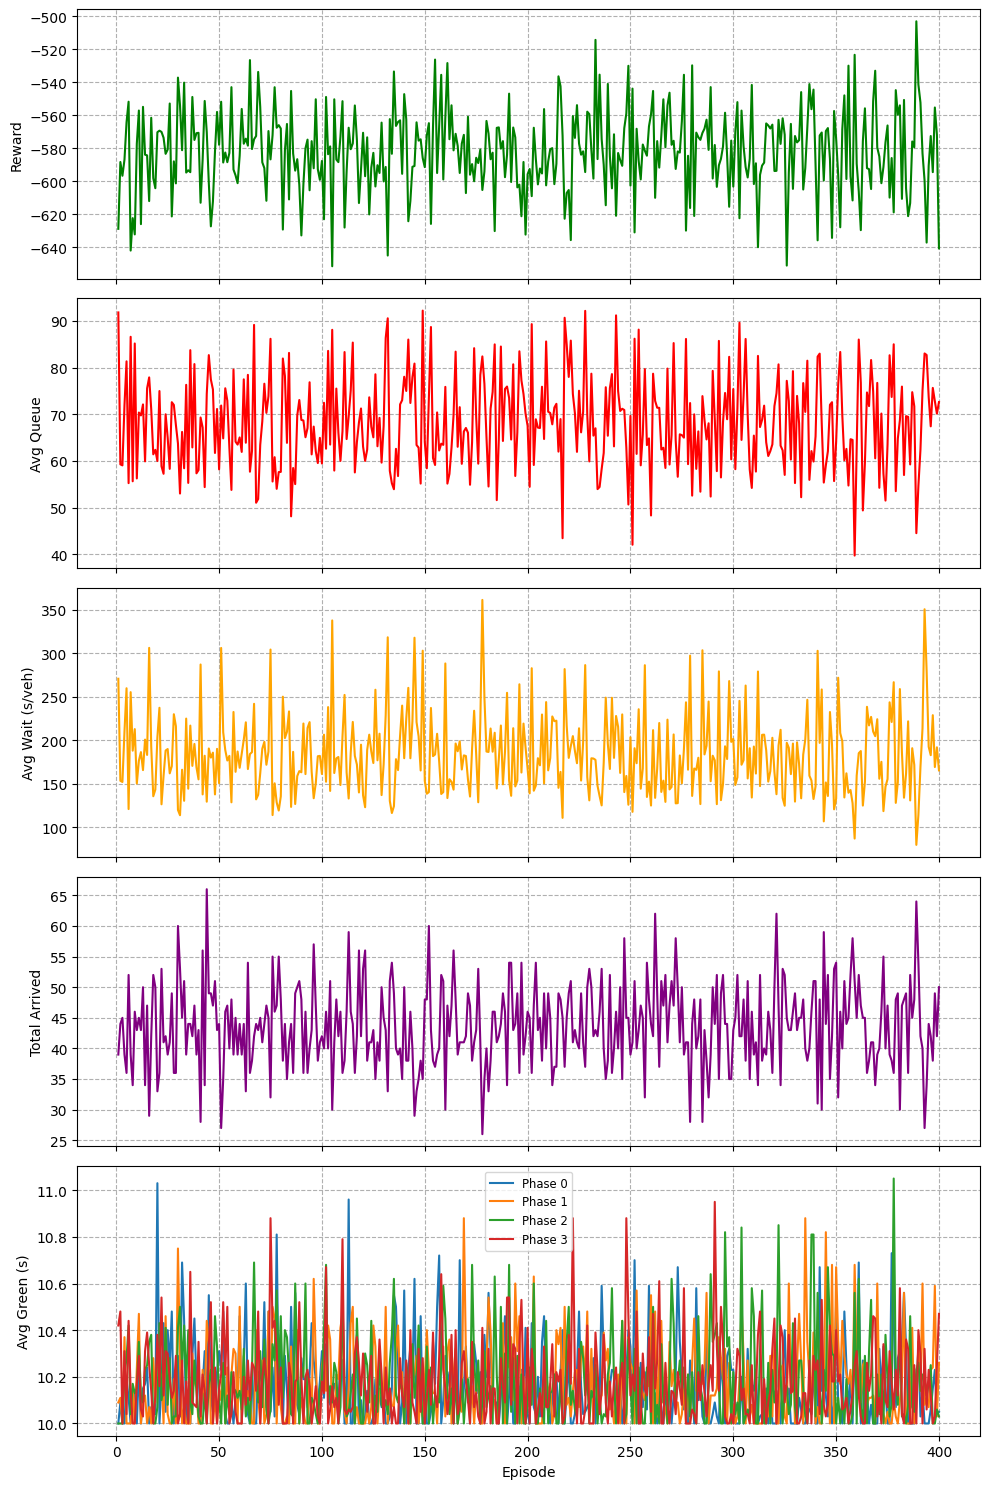

In [18]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing

# ==============================================================================
# 1. HYPERPARAMETERS
# ==============================================================================
STATE_DIM = 32
PHASE_DIM = 4
HIDDEN_1 = 128
HIDDEN_2 = 64
ACTION_CONTINUOUS_DIM = 1

# Output Limits
MIN_DURATION = 10.0  # Keep 10s min to allow flexibility
MAX_DURATION = 60.0 

# Training Hyperparameters
LR = 5e-4
GAMMA = 0.95 
ENTROPY_BETA = 0.05 
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v5_a2c_switching_tax.pth" # New Checkpoint Name

# --- Reward Weights ---
REWARD_WEIGHT_WAIT_TIME = 0.05
REWARD_WEIGHT_MAX_WAIT = 0.1     
REWARD_WEIGHT_DURATION = 0.5     
REWARD_WEIGHT_QUEUE_DIFF = 0.2   
BUMPER_REWARD_BONUS = 2.0        
BUMPER_THRESHOLD = 2

# --- Normalization Factors ---
NORM_MAX_QUEUE = 20.0  
NORM_MAX_WAIT = 100.0  
NORM_MAX_SPEED = 15.0  

# --- Simulation Configuration ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 400 

# --- Environment Parameters ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# ==============================================================================
# 2. ACTOR-CRITIC NETWORK
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({'model_state_dict': self.net.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        # Try to load previous v3 model to continue training, or start fresh
        paths = [self.checkpoint_path, "v3_a2c_checkpoint.pth"]
        for path in paths:
            try:
                checkpoint = torch.load(path, map_location=self.device)
                self.net.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print(f"Model loaded successfully from {path}")
                return
            except FileNotFoundError: continue
        print("No checkpoint found. Starting training from scratch.")

# ==============================================================================
# 4. TRAFFIC AGENT (UPDATED WITH SWITCHING TAX)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string, min_green_time=10, yellow_time=2, all_red_time=1):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        
        # NEW: Track last phase to calculate switching penalty
        self.last_action_phase = -1
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_state(self):
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)
        waiting_times = []
        for lane_id in self.incoming_lanes:
            try: w = traci.lane.getWaitingTime(lane_id)
            except: w = 0
            waiting_times.append(w)

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN": self.phase_one_hot[self.current_phase_index] = 1.0
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])

    # UPDATED GET_REWARD: Accepts action_phase
    def get_reward(self, chosen_duration, action_phase):
        r_wait_penalty = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)
        r_max_wait_penalty = -REWARD_WEIGHT_MAX_WAIT * np.max(self.current_waiting_times)
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        r_bumper = BUMPER_REWARD_BONUS if Q_t_plus_1 < BUMPER_THRESHOLD else 0.0
        duration_norm = (chosen_duration - MIN_DURATION) / (MAX_DURATION - MIN_DURATION)
        r_duration = duration_norm * REWARD_WEIGHT_DURATION
        
        # --- SWITCHING PENALTY ---
        # If phase changes, apply negative reward to discourage thrashing
        if self.last_action_phase != -1 and action_phase != self.last_action_phase:
            r_switch = -5.0 
        else:
            r_switch = 0.0

        return r_wait_penalty + r_max_wait_penalty + r_queue_diff + r_bumper + r_duration + r_switch

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): traci.simulationStep()
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): traci.simulationStep()
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            for _ in range(green_duration): traci.simulationStep()
        except traci.TraCIException: pass
        
        # 1. GET NEW STATE (Must happen before return!)
        new_state = self.get_state()
        
        # 2. CALCULATE REWARD (Passing the new phase)
        reward = self.get_reward(green_duration, next_green_phase_index)
        
        # 3. UPDATE LAST ACTION
        self.last_action_phase = next_green_phase_index
        
        return new_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except: total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0
        return { 'total_halting': total_halting, 'total_wait_sec': total_waiting, 'avg_speed': avg_spd, 'throughput_step': throughput, 'arrived_in_step': arrived_in_step }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)

# ==============================================================================
# 5. SUMO UTILS (CRASH-SAFE)
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    print(f"Starting SUMO on port {port}...")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            print(f"TraCI Connected on port {port}.")
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    print("TraCI Connection Failed.")
    stop_sumo()
    return False

# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model() # Will try to load v3 or v5, or start fresh
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times, ep_queue_lengths = [], [], [], [], []
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_state()
            total_reward = 0
            step_counter = 0
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                
                # This step call is now SAFE
                new_state, reward, done, _ = traffic_env.step(action)
                
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1
                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM): axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')
    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

In [ ]:
###v6
"""
To fix this, we need to flip the psychology of the AI. Instead of punishing it for failure (waiting), we need to reward it aggressively for success (throughput).

Here is v6: The "Greedy" Agent.

The "Hard Core" Changes (v6)
Throughput Bonus (New): We will give the agent +10.0 points for every single car that exits the simulation.

Effect: The agent will realize: "Transitions are bad not just because of the tax, but because no cars arrive during a transition. I can't get my +10 bonus if the light is yellow!"

Reduce "Anxiety": We are slashing REWARD_WEIGHT_WAIT_TIME from 0.05 to 0.001.

Effect: We stop screaming at the agent about the queue. We let it focus on the prize (clearing cars) rather than the problem (waiting cars).

Queue Cleaning Boost: We increase REWARD_WEIGHT_QUEUE_DIFF from 0.2 to 1.0.

Effect: Big reward for visually clearing a lane.
"""

Starting training from scratch (Recommended for v6 logic shift).
Starting SUMO on port 42931...
TraCI Connected on port 42931.

--- EPISODE 1/800 ---
Reward: 5117 | Avg Wait/Veh: 215.0s | Served: 32 | Avg Q: 59.3
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 2/800 ---
Reward: 4389 | Avg Wait/Veh: 249.2s | Served: 46 | Avg Q: 98.8
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 3/800 ---
Reward: 5900 | Avg Wait/Veh: 136.6s | Served: 49 | Avg Q: 57.7
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 4/800 ---
Reward: 5664 | Avg Wait/Veh: 135.6s | Served: 44 | Avg Q: 51.4
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 5/800 ---
Reward: 4559 | Avg Wait/Veh: 280.0s | Served: 36 | Avg Q: 86.9
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 6/800 ---
Reward: 5747 | Avg Wait/Veh: 194.9s | Served: 39 | Avg Q: 65.5
  Avg Green Times: P0: 10.0s | P

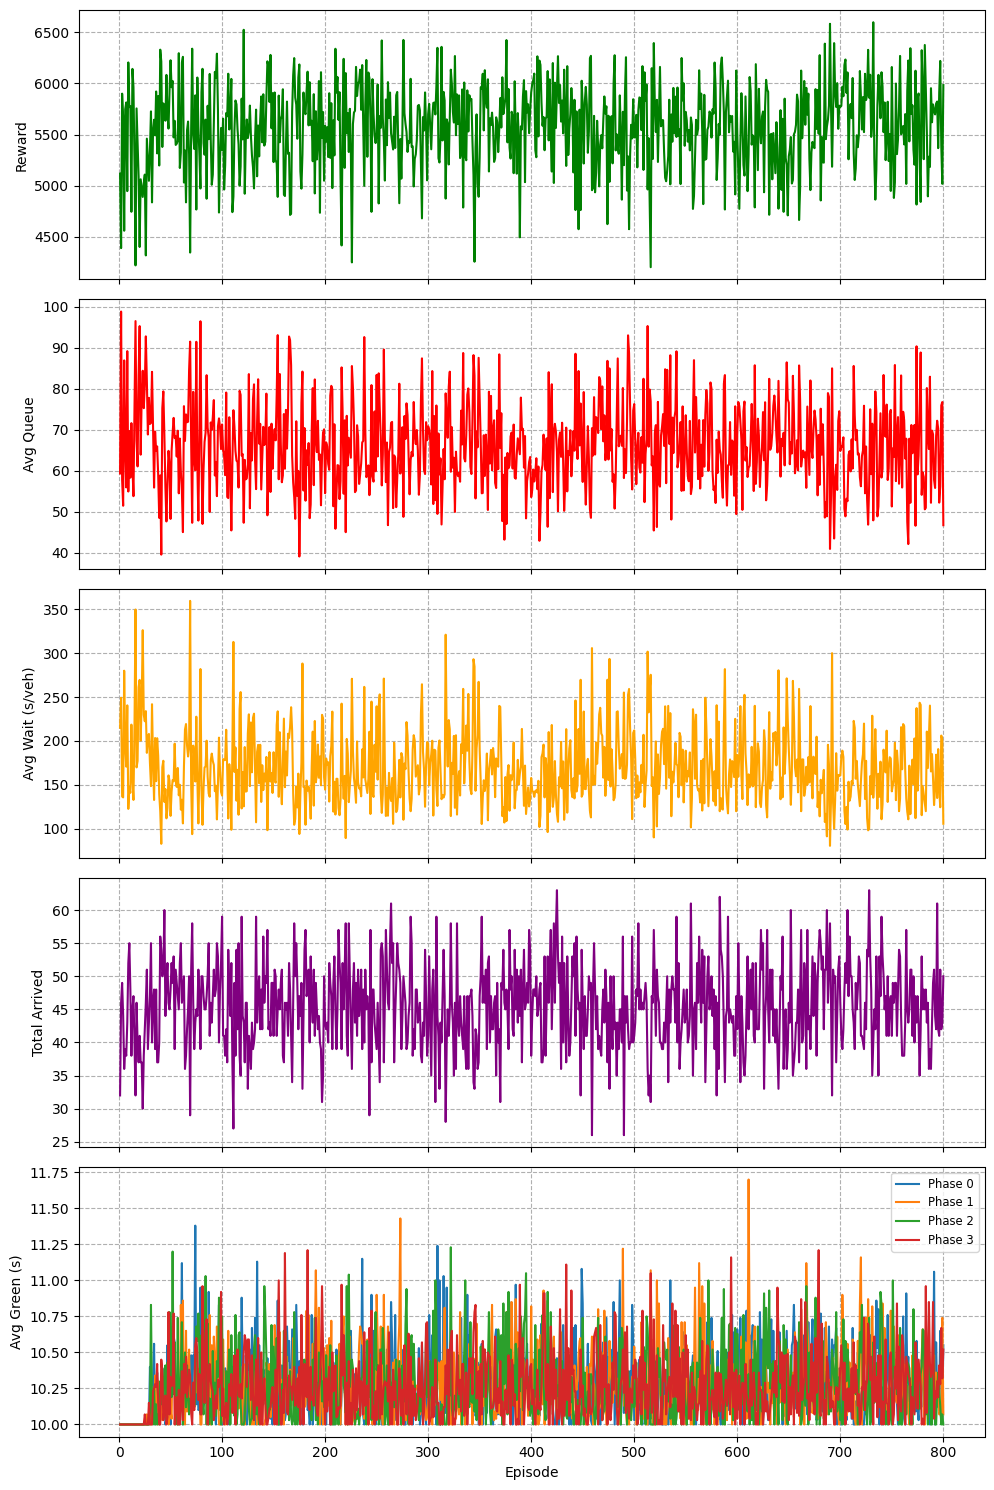

In [7]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing

# ==============================================================================
# 1. HYPERPARAMETERS (v6 - GREEDY MODE)
# ==============================================================================
STATE_DIM = 32
PHASE_DIM = 4
HIDDEN_1 = 128
HIDDEN_2 = 64
ACTION_CONTINUOUS_DIM = 1

# Output Limits
MIN_DURATION = 10.0
MAX_DURATION = 60.0 

# Training Hyperparameters
LR = 5e-4
GAMMA = 0.99 # Increased to 0.99 to value future throughput more
ENTROPY_BETA = 0.05 
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v6_a2c_throughput.pth" # New Checkpoint

# --- AGGRESSIVE REWARD WEIGHTS ---
# Strategy: Minimize "Pain" signals, Maximize "Pleasure" signals
REWARD_WEIGHT_WAIT_TIME = 0.001  # Tiny penalty. Stop panicking about wait time.
REWARD_WEIGHT_MAX_WAIT = 0.05    # Tiny penalty.
REWARD_WEIGHT_DURATION = 0.0     # Removed. Don't reward existing, reward doing work.
REWARD_WEIGHT_QUEUE_DIFF = 1.0   # Big bonus for reducing the queue number.
REWARD_WEIGHT_THROUGHPUT = 10.0  # HUGE bonus for every car that finishes.
BUMPER_REWARD_BONUS = 0.0        # Removed to simplify. Throughput covers this.

# --- Normalization Factors ---
NORM_MAX_QUEUE = 20.0  
NORM_MAX_WAIT = 100.0  
NORM_MAX_SPEED = 15.0  

# --- Simulation Configuration ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 800 

# --- Environment Parameters ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# ==============================================================================
# 2. ACTOR-CRITIC NETWORK
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({'model_state_dict': self.net.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        # Start fresh if we change rewards this drastically, or try to load v5
        paths = [self.checkpoint_path]
        for path in paths:
            try:
                checkpoint = torch.load(path, map_location=self.device)
                self.net.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print(f"Model loaded successfully from {path}")
                return
            except FileNotFoundError: continue
        print("Starting training from scratch (Recommended for v6 logic shift).")

# ==============================================================================
# 4. TRAFFIC AGENT (v6 - THROUGHPUT TRACKING)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string, min_green_time=10, yellow_time=2, all_red_time=1):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        
        self.last_action_phase = -1
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_state(self):
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)
        waiting_times = []
        for lane_id in self.incoming_lanes:
            try: w = traci.lane.getWaitingTime(lane_id)
            except: w = 0
            waiting_times.append(w)

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN": self.phase_one_hot[self.current_phase_index] = 1.0
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])

    # NEW: Reward accepts 'arrived_count'
    def get_reward(self, chosen_duration, action_phase, arrived_count):
        r_wait_penalty = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)
        r_max_wait_penalty = -REWARD_WEIGHT_MAX_WAIT * np.max(self.current_waiting_times)
        
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        
        # --- THROUGHPUT REWARD (THE FIX) ---
        # Massive bonus for every car that leaves
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        
        # Switching penalty (Keep -5.0 to ensure they only switch if they get throughput > 0.5 cars)
        if self.last_action_phase != -1 and action_phase != self.last_action_phase:
            r_switch = -5.0 
        else:
            r_switch = 0.0

        return r_wait_penalty + r_max_wait_penalty + r_queue_diff + r_throughput + r_switch

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        
        arrived_in_action = 0
        
        try:
            # Yellow
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() # Check arrivals during yellow
            
            # All Red
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            
            # Green
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            
            # Run Green Duration and count arrivals
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
                
        except traci.TraCIException: pass
        
        new_state = self.get_state()
        
        # Pass arrived count to reward function
        reward = self.get_reward(green_duration, next_green_phase_index, arrived_in_action)
        
        self.last_action_phase = next_green_phase_index
        
        return new_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except: total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0
        return { 'total_halting': total_halting, 'total_wait_sec': total_waiting, 'avg_speed': avg_spd, 'throughput_step': throughput, 'arrived_in_step': arrived_in_step }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)

# ==============================================================================
# 5. SUMO UTILS
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    print(f"Starting SUMO on port {port}...")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            print(f"TraCI Connected on port {port}.")
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    print("TraCI Connection Failed.")
    stop_sumo()
    return False

# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model()
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times, ep_queue_lengths = [], [], [], [], []
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_state()
            total_reward = 0
            step_counter = 0
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1
                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM): axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')
    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

In [ ]:
#v7
"""
The "Ultra-Aggressive" v7 Strategy
Wait Penalty = 0.0: We are removing the penalty for waiting cars completely. Let them wait. The agent should no longer feel "anxiety" about a red light.

Throughput Bonus = +50.0: Every single car that leaves the intersection is a massive jackpot. This forces the agent to maximize flow.

Why this fixes thrashing: You cannot get throughput during the Yellow/Red transition (3-4 seconds of dead time). If the agent flickers the lights, it earns 0 points. It must hold the green light to collect the +50 rewards.

Entropy = 0.1 (Doubled): We are forcing the agent to try wild new strategies (like holding a green light for 50 seconds) to see if it hits a jackpot.
"""

Starting training from scratch (v7 Aggressive).
Starting SUMO on port 47493...
TraCI Connected on port 47493.

--- EPISODE 1/400 ---
Reward: 185101 | Avg Wait/Veh: 217.6s | Served: 46 | Avg Q: 86.3
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 2/400 ---
Reward: 377187 | Avg Wait/Veh: 153.4s | Served: 48 | Avg Q: 63.5
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 3/400 ---
Reward: 206887 | Avg Wait/Veh: 263.5s | Served: 35 | Avg Q: 79.5
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 4/400 ---
Reward: 357143 | Avg Wait/Veh: 204.5s | Served: 42 | Avg Q: 74.0
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 5/400 ---
Reward: 218382 | Avg Wait/Veh: 282.4s | Served: 38 | Avg Q: 92.5
  Avg Green Times: P0: 10.0s | P1: 10.0s | P2: 10.0s | P3: 10.0s

--- EPISODE 6/400 ---
Reward: 238782 | Avg Wait/Veh: 269.3s | Served: 34 | Avg Q: 78.9
  Avg Green Times: P0: 10.0s | P1: 10

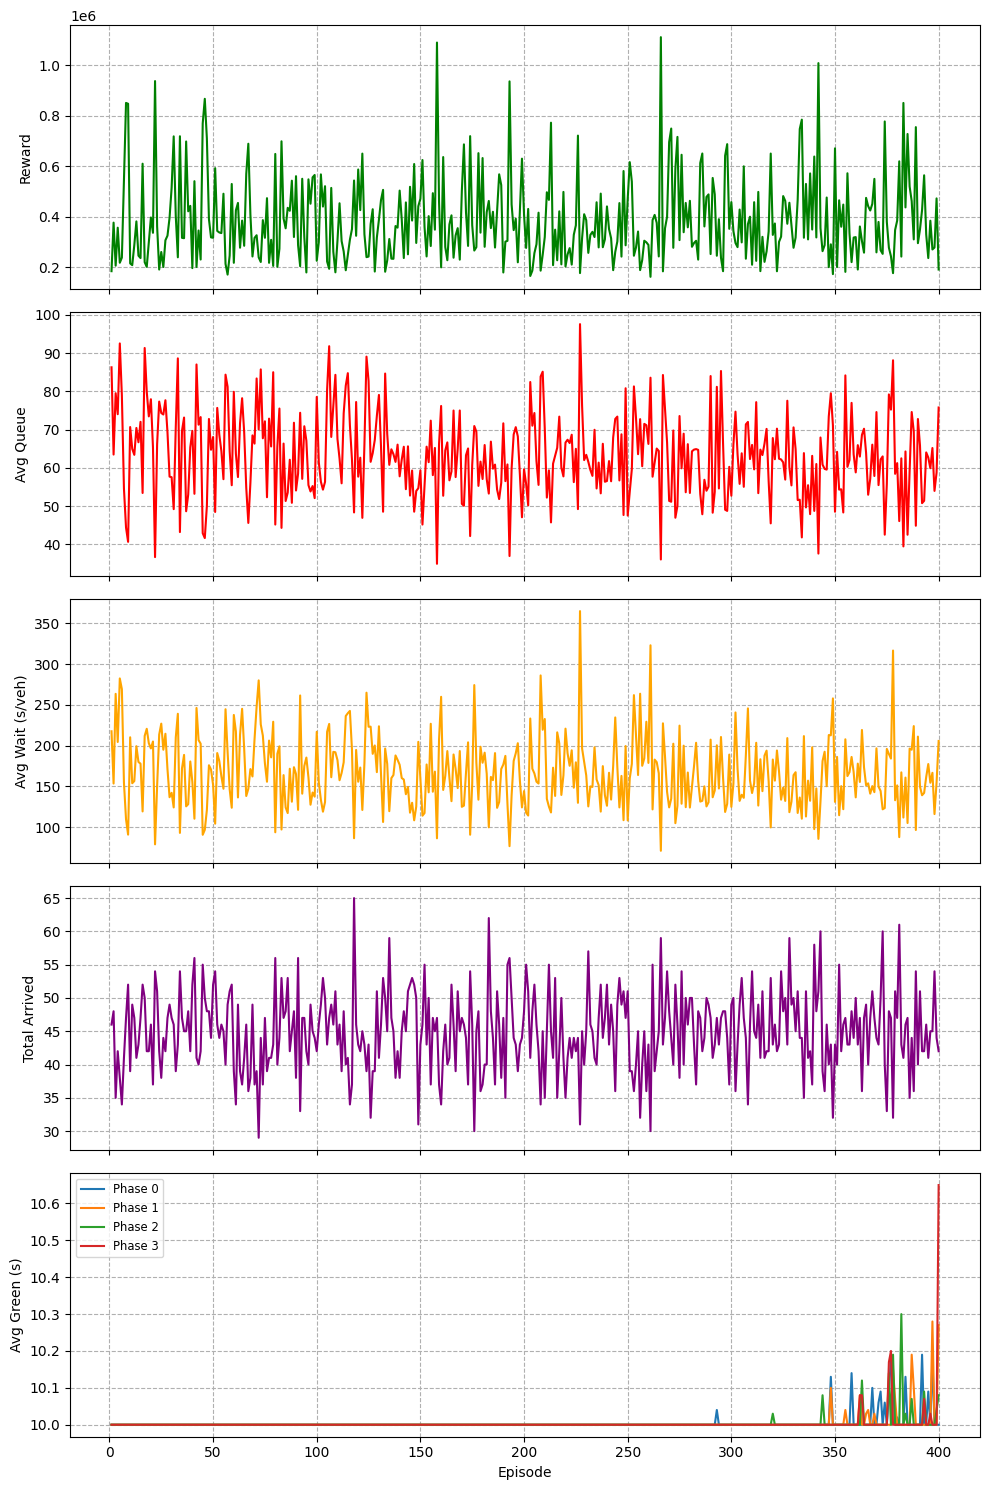

In [6]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing

# ==============================================================================
# 1. HYPERPARAMETERS (v7 - NUCLEAR OPTION)
# ==============================================================================
STATE_DIM = 32
PHASE_DIM = 4
HIDDEN_1 = 128
HIDDEN_2 = 64
ACTION_CONTINUOUS_DIM = 1

# Output Limits
MIN_DURATION = 10.0
MAX_DURATION = 70.0 

  
# Training Hyperparameters
LR = 2e-5  # Aggressive Learning Rate (was 5e-4)
GAMMA = 0.995 # Look waaaay into the future (Maximize long-term flow)
ENTROPY_BETA = 0.09 # High Entropy: Force it to try random long durations
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v7_aggressive.pth" 


# REWARD_WEIGHT_WAIT_TIME = 0.001  # Tiny penalty. Stop panicking about wait time.
# REWARD_WEIGHT_MAX_WAIT = 0.05    # Tiny penalty.
# REWARD_WEIGHT_DURATION = 0.0     # Removed. Don't reward existing, reward doing work.
# REWARD_WEIGHT_QUEUE_DIFF = 1.0   # Big bonus for reducing the queue number.
# REWARD_WEIGHT_THROUGHPUT = 10.0  # HUGE bonus for every car that finishes.
# BUMPER_REWARD_BONUS = 0.0 
# BUMPER_THRESHOLD = 45
# --- REWARD WEIGHTS (THE SHIFT) ---
# We ignore "pain" (waiting) and only reward "gain" (throughput)
REWARD_WEIGHT_WAIT_TIME = 0.0099    # ZERO. We don't care if they wait.
REWARD_WEIGHT_MAX_WAIT = 0.02     # ZERO. 
REWARD_WEIGHT_DURATION = 1.0    
REWARD_WEIGHT_QUEUE_DIFF = 2.0   # High bonus for clearing lanes
REWARD_WEIGHT_THROUGHPUT = 200.0  # JACKPOT for every car served
BUMPER_REWARD_BONUS = 10000.0  
BUMPER_THRESHOLD = 45

# --- Normalization Factors ---
NORM_MAX_QUEUE = 25.0  
NORM_MAX_WAIT = 100.0  
NORM_MAX_SPEED = 15.0  

# --- Simulation Configuration ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 400 

# --- Environment Parameters ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# ==============================================================================
# 2. ACTOR-CRITIC NETWORK
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({'model_state_dict': self.net.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        # We start FRESH because the reward function is completely different
        print("Starting training from scratch (v7 Aggressive).")

# ==============================================================================
# 4. TRAFFIC AGENT (v7 - THROUGHPUT KING)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string, min_green_time=10, yellow_time=2, all_red_time=1):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        
        self.last_action_phase = -1
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_state(self):
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)
        waiting_times = []
        for lane_id in self.incoming_lanes:
            try: w = traci.lane.getWaitingTime(lane_id)
            except: w = 0
            waiting_times.append(w)

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN": self.phase_one_hot[self.current_phase_index] = 1.0
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])

    def get_reward(self, chosen_duration, action_phase, arrived_count):
        # We ignore wait time penalties. We only care about flow.
        r_wait_penalty = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)
        r_max_wait_penalty = -REWARD_WEIGHT_MAX_WAIT * np.max(self.current_waiting_times)
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        r_bumper = BUMPER_REWARD_BONUS if Q_t_plus_1 < BUMPER_THRESHOLD else 0.0
        duration_norm = (chosen_duration - MIN_DURATION) / (MAX_DURATION - MIN_DURATION)
        r_duration = duration_norm * REWARD_WEIGHT_DURATION
        
        # MASSIVE BONUS FOR THROUGHPUT
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        
        # Switching penalty (Keep -5.0. It's now small compared to the +50 bonus, but still relevant)
        if self.last_action_phase != -1 and action_phase != self.last_action_phase:
            r_switch = -5.0 
        else:
            r_switch = 0.0

        return r_queue_diff + r_throughput + r_switch + r_bumper + r_duration + r_wait_penalty + r_max_wait_penalty



    
    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        
        arrived_in_action = 0
        
        try:
            # Yellow
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() 
            
            # All Red
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            
            # Green
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            
            # Run Green Duration
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
                
        except traci.TraCIException: pass
        
        new_state = self.get_state()
        reward = self.get_reward(green_duration, next_green_phase_index, arrived_in_action)
        self.last_action_phase = next_green_phase_index
        return new_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except: total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0
        return { 'total_halting': total_halting, 'total_wait_sec': total_waiting, 'avg_speed': avg_spd, 'throughput_step': throughput, 'arrived_in_step': arrived_in_step }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)

# ==============================================================================
# 5. SUMO UTILS
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    print(f"Starting SUMO on port {port}...")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            print(f"TraCI Connected on port {port}.")
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    print("TraCI Connection Failed.")
    stop_sumo()
    return False

# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model()
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times, ep_queue_lengths = [], [], [], [], []
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_state()
            total_reward = 0
            step_counter = 0
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1
                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM): axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')
    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

In [ ]:
#v9

Starting training from scratch (v9 FrameStack).
Starting SUMO on port 55845...
TraCI Connected on port 55845.

--- EPISODE 1/1000 ---
Reward: 4602 | Avg Wait/Veh: 189.9s | Served: 20 | Avg Q: 82.6
  Avg Green Times: P0: 30.0s | P1: 30.0s | P2: 30.0s | P3: 30.0s

--- EPISODE 2/1000 ---
Reward: 5243 | Avg Wait/Veh: 198.2s | Served: 19 | Avg Q: 81.8
  Avg Green Times: P0: 30.0s | P1: 30.0s | P2: 30.0s | P3: 30.0s

--- EPISODE 3/1000 ---
Reward: 4231 | Avg Wait/Veh: 209.3s | Served: 19 | Avg Q: 86.4
  Avg Green Times: P0: 30.0s | P1: 30.0s | P2: 30.0s | P3: 30.0s

--- EPISODE 4/1000 ---
Reward: 4249 | Avg Wait/Veh: 214.5s | Served: 22 | Avg Q: 102.6
  Avg Green Times: P0: 30.0s | P1: 30.0s | P2: 30.0s | P3: 30.0s

--- EPISODE 5/1000 ---
Reward: 4349 | Avg Wait/Veh: 157.0s | Served: 23 | Avg Q: 78.5
  Avg Green Times: P0: 30.0s | P1: 30.0s | P2: 30.0s | P3: 30.0s

--- EPISODE 6/1000 ---
Reward: 5286 | Avg Wait/Veh: 203.7s | Served: 20 | Avg Q: 88.5
  Avg Green Times: P0: 30.0s | P1: 30.0s |

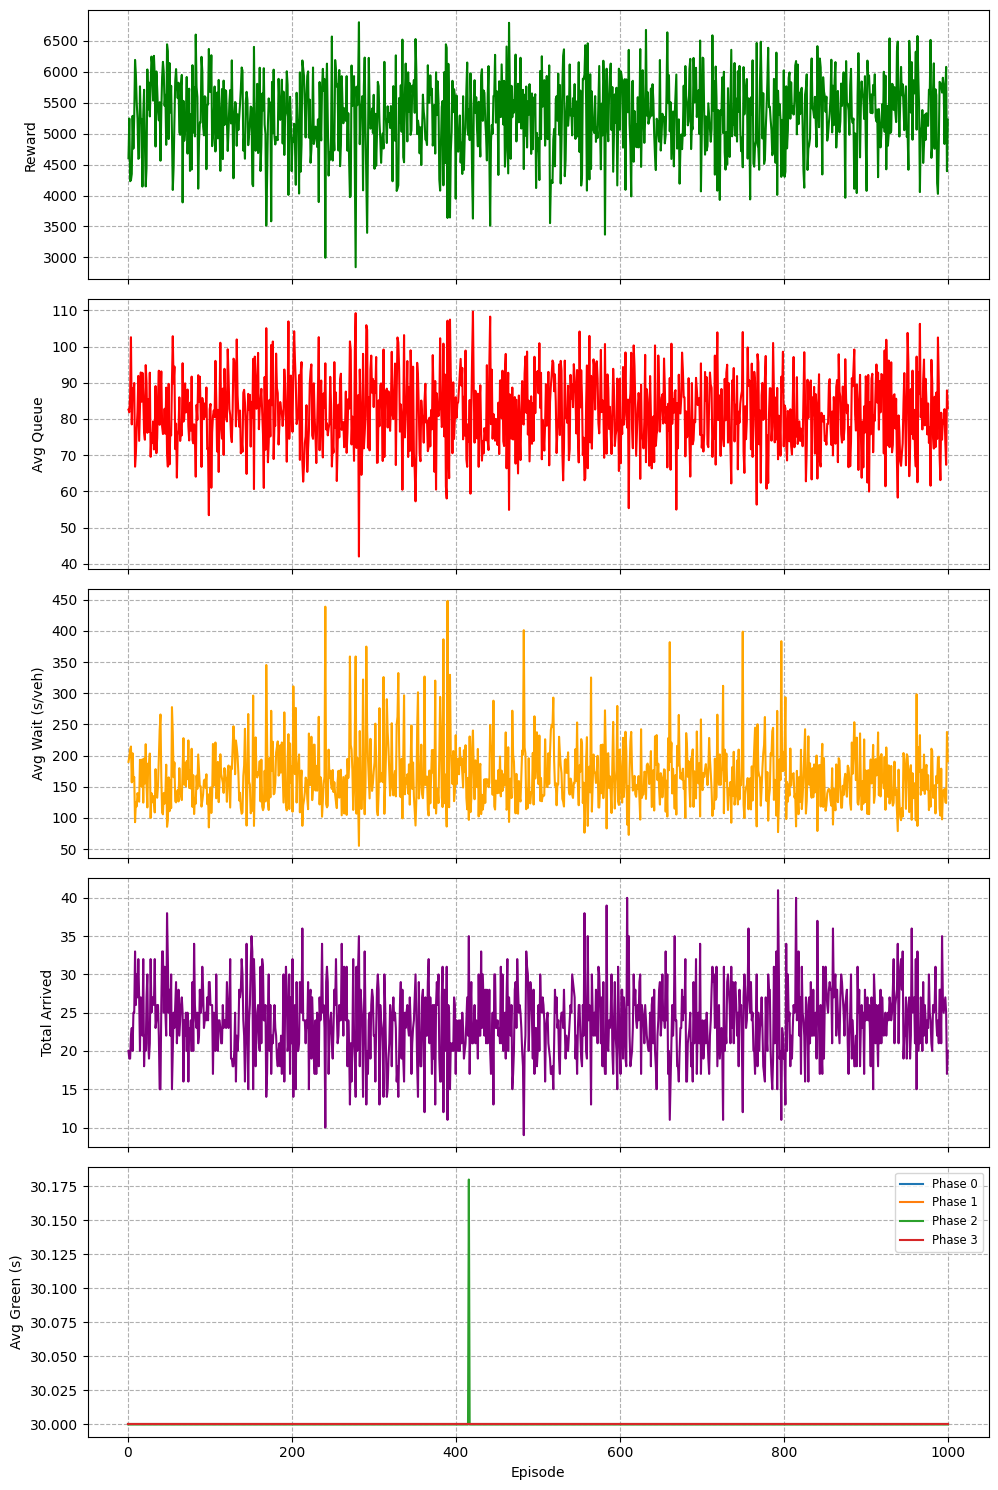

In [10]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing
from collections import deque

# ==============================================================================
# 1. HYPERPARAMETERS (v9 - FRAME STACKING)
# ==============================================================================
# --- Architecture ---
SINGLE_STATE_DIM = 32
STACK_SIZE = 4  # Look at last 4 decisions
STATE_DIM = SINGLE_STATE_DIM * STACK_SIZE # 128 Input Nodes

PHASE_DIM = 4
HIDDEN_1 = 256 # Increased capacity for larger input
HIDDEN_2 = 128
ACTION_CONTINUOUS_DIM = 1

# Output Limits
MIN_DURATION = 30.0
MAX_DURATION = 60.0 

# Training
LR = 5e-4
GAMMA = 0.99 
ENTROPY_BETA = 0.05 
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v9_framestack.pth" 

# --- Rewards (Throughput Focus + Switching Tax) ---
REWARD_WEIGHT_WAIT_TIME = 0.001  # Low penalty
REWARD_WEIGHT_MAX_WAIT = 0.05    
REWARD_WEIGHT_QUEUE_DIFF = 1.0   # Good bonus for clearing
REWARD_WEIGHT_THROUGHPUT = 10.0  # MAIN GOAL: Move cars
BUMPER_REWARD_BONUS = 0.0        

# --- Normalization ---
NORM_MAX_QUEUE = 20.0  
NORM_MAX_WAIT = 100.0  
NORM_MAX_SPEED = 15.0  

# --- Config ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 1000

# --- Environment ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# ==============================================================================
# 2. ACTOR-CRITIC NETWORK (UPDATED INPUT SIZE)
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        # Input is now 128 dim (Stacked Frames)
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({'model_state_dict': self.net.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        # New architecture means new weights. Start fresh.
        print("Starting training from scratch (v9 FrameStack).")

# ==============================================================================
# 4. TRAFFIC AGENT (FRAME STACKING LOGIC)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string, min_green_time=10, yellow_time=2, all_red_time=1):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        self.last_action_phase = -1

        # State History for Stacking
        self.state_stack = deque(maxlen=STACK_SIZE)
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_raw_state(self):
        # Helper to get a SINGLE state frame (32 dims)
        queue_lengths = []
        lane_speeds = []
        for det_id in self.incoming_detectors:
            try:
                q = traci.lanearea.getLastStepHaltingNumber(det_id)
                s = traci.lanearea.getLastStepMeanSpeed(det_id)
            except: q=0; s=0.0
            queue_lengths.append(q)
            lane_speeds.append(s)
        waiting_times = []
        for lane_id in self.incoming_lanes:
            try: w = traci.lane.getWaitingTime(lane_id)
            except: w = 0
            waiting_times.append(w)

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN": self.phase_one_hot[self.current_phase_index] = 1.0
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])

    def get_stacked_state(self):
        # If stack is empty (start of episode), fill with current state
        if len(self.state_stack) == 0:
            initial = self.get_raw_state()
            for _ in range(STACK_SIZE):
                self.state_stack.append(initial)
        
        # Flatten stack into one big vector (128 dims)
        return np.concatenate(self.state_stack)

    def get_reward(self, chosen_duration, action_phase, arrived_count):
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        
        # Throughput Bonus
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        
        # Switching Tax (Fixes Thrashing)
        if self.last_action_phase != -1 and action_phase != self.last_action_phase:
            r_switch = -5.0 
        else:
            r_switch = 0.0

        # Small wait penalty (v6 style)
        r_wait = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)

        return r_queue_diff + r_throughput + r_switch + r_wait

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        
        arrived_in_action = 0
        
        try:
            # Yellow
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() 
            
            # All Red
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            
            # Green
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            
            # Run Green Duration
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
                
        except traci.TraCIException: pass
        
        # 1. Update Stack with NEWEST frame
        new_raw_state = self.get_raw_state()
        self.state_stack.append(new_raw_state) # Oldest frame pops off automatically
        
        new_stacked_state = self.get_stacked_state()
        
        reward = self.get_reward(green_duration, next_green_phase_index, arrived_in_action)
        self.last_action_phase = next_green_phase_index
        return new_stacked_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except: total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0
        return { 'total_halting': total_halting, 'total_wait_sec': total_waiting, 'avg_speed': avg_spd, 'throughput_step': throughput, 'arrived_in_step': arrived_in_step }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)

# ==============================================================================
# 5. SUMO UTILS
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    print(f"Starting SUMO on port {port}...")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            print(f"TraCI Connected on port {port}.")
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    print("TraCI Connection Failed.")
    stop_sumo()
    return False

# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model()
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times, ep_queue_lengths = [], [], [], [], []
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            
            # IMPORTANT: Get initial stacked state
            state = traffic_env.get_stacked_state()
            
            total_reward = 0
            step_counter = 0
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1
                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM): axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')
    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

In [ ]:
#v10

In [ ]:
#v10
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing
from collections import deque

# ==============================================================================
# 1. HYPERPARAMETERS (v10 - HEAVY TRAFFIC OPTIMIZED)
# ==============================================================================
# --- Architecture ---
SINGLE_STATE_DIM = 32
STACK_SIZE = 4  
STATE_DIM = SINGLE_STATE_DIM * STACK_SIZE 

PHASE_DIM = 4
HIDDEN_1 = 256 
HIDDEN_2 = 128
ACTION_CONTINUOUS_DIM = 1

# Output Limits (CRITICAL FOR RICKSHAWS)
MIN_DURATION = 15.0  # Force long cycles to clear slow start-up traffic
MAX_DURATION = 80.0  # Allow very long greens for heavy flow

# Training
LR = 1e-4  # Precision Learning Rate
GAMMA = 0.99 
ENTROPY_BETA = 0.05 
TRAINING_BATCH_SIZE = 128
CHECKPOINT_PATH = "v10_heavy_traffic.pth" 

# --- Rewards ---
REWARD_WEIGHT_WAIT_TIME = 0.001  
REWARD_WEIGHT_MAX_WAIT = 0.05    
REWARD_WEIGHT_QUEUE_DIFF = 2.0   # Increased to value clearing lanes
REWARD_WEIGHT_THROUGHPUT = 20.0  # Strong bonus for flow
BUMPER_REWARD_BONUS = 0.0        

# --- Normalization ---
NORM_MAX_QUEUE = 50.0   # Increased scale for Heavy Traffic
NORM_MAX_WAIT = 200.0   # Increased scale for Heavy Traffic
NORM_MAX_SPEED = 15.0  

# --- Config ---
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 2000 

# --- Environment ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# ==============================================================================
# 2. ACTOR-CRITIC NETWORK (OPTIMIZED INIT)
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

        # --- CRITICAL FIX: BIAS INITIALIZATION ---
        # Force the network to start guessing ~30s instead of 0s
        with torch.no_grad():
            self.actor_duration_mu.bias.data.fill_(35.0)
            self.actor_duration_log_std.bias.data.fill_(-1.0) # Low variance start

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 3. A2C AGENT CLASS
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, lr=LR, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        
        # CLIPPING
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - ENTROPY_BETA * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({'model_state_dict': self.net.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        if os.path.exists(self.checkpoint_path):
             try:
                checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
                self.net.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print(f"Resuming from {self.checkpoint_path}")
                return
             except: pass
        print("Starting FRESH v10 Model.")

# ==============================================================================
# 4. TRAFFIC AGENT
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string, min_green_time=10, yellow_time=2, all_red_time=1):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        self.last_action_phase = -1
        self.state_stack = deque(maxlen=STACK_SIZE)
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_raw_state(self):
        queue_lengths = [traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors]
        lane_speeds = [traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors]
        waiting_times = [traci.lane.getWaitingTime(l) for l in self.incoming_lanes]

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN": self.phase_one_hot[self.current_phase_index] = 1.0
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])

    def get_stacked_state(self):
        if len(self.state_stack) == 0:
            initial = self.get_raw_state()
            for _ in range(STACK_SIZE): self.state_stack.append(initial)
        return np.concatenate(self.state_stack)

    def get_reward(self, chosen_duration, action_phase, arrived_count):
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        r_switch = -5.0 if (self.last_action_phase != -1 and action_phase != self.last_action_phase) else 0.0
        r_wait = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)
        return r_queue_diff + r_throughput + r_switch + r_wait

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        arrived_in_action = 0
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() 
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
        except traci.TraCIException: pass
        
        new_raw_state = self.get_raw_state()
        self.state_stack.append(new_raw_state)
        new_stacked_state = self.get_stacked_state()
        reward = self.get_reward(green_duration, next_green_phase_index, arrived_in_action)
        self.last_action_phase = next_green_phase_index
        return new_stacked_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except: total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0
        return { 'total_halting': total_halting, 'total_wait_sec': total_waiting, 'avg_speed': avg_spd, 'throughput_step': throughput, 'arrived_in_step': arrived_in_step }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)

# ==============================================================================
# 5. SUMO UTILS
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    print(f"Starting SUMO on port {port}...")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            print(f"TraCI Connected on port {port}.")
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    print("TraCI Connection Failed.")
    stop_sumo()
    return False

# ==============================================================================
# 6. TRAINING LOOP
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model()
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times, ep_queue_lengths = [], [], [], [], []
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_stacked_state()
            
            total_reward = 0
            step_counter = 0
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1
                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM): axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')
    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

In [ ]:
#v11
'''
v11: The "Scout & Miner" Architecture
Here is the plan to implement your idea:

Episodes 0 - 500 (The Scout):

High Learning Rate (5e-4): Take big steps to find the "good valley" quickly.

High Entropy (0.05): Force it to try random durations so it doesn't get stuck in the 10s trap.

Goal: Just find the general strategy (Long Green Times).

Episodes 501 - 2000 (The Miner):

Low Learning Rate (1e-5): Drop the speed by 50x. Take tiny, precise steps.

Low Entropy (0.001): Stop exploring. Exploit the best strategy found so far.

Goal: Stabilize the graph and push throughput to the theoretical maximum.
'''

Starting FRESH v11 Model.
Starting SUMO on port 35271...
TraCI Connected on port 35271.

--- EPISODE 1/2000 ---
Reward: 9569 | Avg Wait/Veh: 187.5s | Served: 17 | Avg Q: 79.7
  Avg Green Times: P0: 34.5s | P1: 34.4s | P2: 34.5s | P3: 34.6s

--- EPISODE 2/2000 ---
Reward: 8912 | Avg Wait/Veh: 248.7s | Served: 16 | Avg Q: 99.5
  Avg Green Times: P0: 34.9s | P1: 34.5s | P2: 34.8s | P3: 34.4s

--- EPISODE 3/2000 ---
Reward: 9626 | Avg Wait/Veh: 177.9s | Served: 21 | Avg Q: 93.4
  Avg Green Times: P0: 34.7s | P1: 34.6s | P2: 34.6s | P3: 34.6s

--- EPISODE 4/2000 ---
Reward: 8487 | Avg Wait/Veh: 284.4s | Served: 13 | Avg Q: 92.4
  Avg Green Times: P0: 34.8s | P1: 34.8s | P2: 34.7s | P3: 34.4s

--- EPISODE 5/2000 ---
Reward: 8266 | Avg Wait/Veh: 327.4s | Served: 10 | Avg Q: 81.8
  Avg Green Times: P0: 34.6s | P1: 35.2s | P2: 34.8s | P3: 34.7s

--- EPISODE 6/2000 ---
Reward: 10921 | Avg Wait/Veh: 165.8s | Served: 18 | Avg Q: 74.6
  Avg Green Times: P0: 34.5s | P1: 34.9s | P2: 35.0s | P3: 34.7s

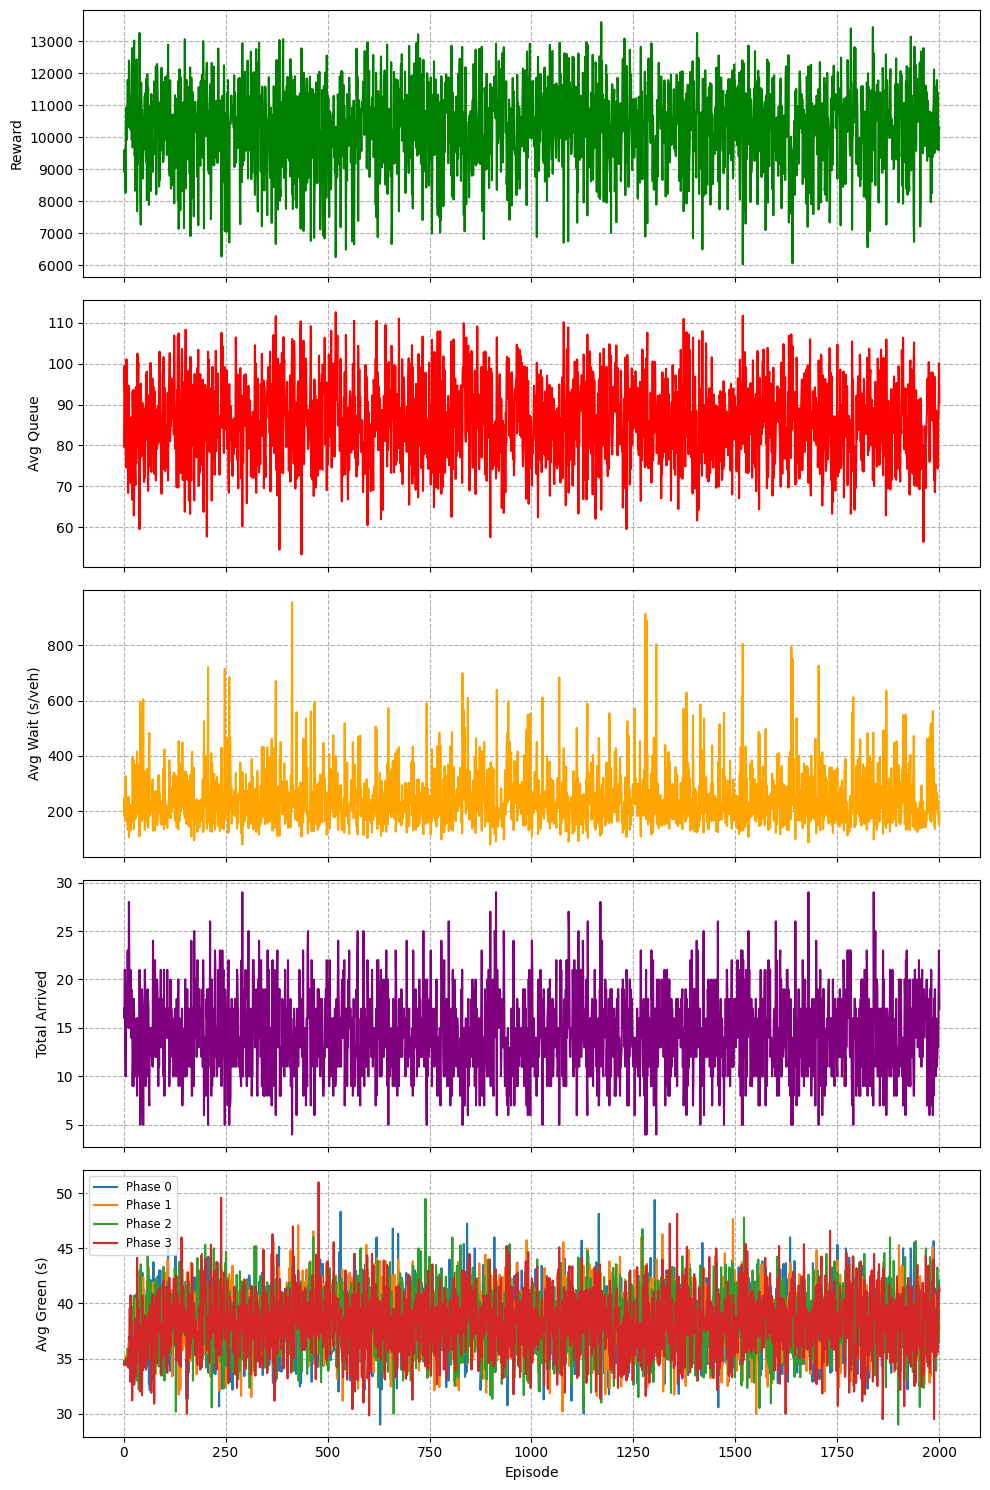

In [11]:
#v11
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing
from collections import deque

# ==============================================================================
# 1. HYPERPARAMETERS (v11 - TWO STAGE STRATEGY)
# ==============================================================================
# --- Architecture ---
SINGLE_STATE_DIM = 32
STACK_SIZE = 4  
STATE_DIM = SINGLE_STATE_DIM * STACK_SIZE 

PHASE_DIM = 4
HIDDEN_1 = 256 
HIDDEN_2 = 128
ACTION_CONTINUOUS_DIM = 1

# --- STAGE 1: THE SCOUT (Fast & Curious) ---
SCOUT_EPISODES = 600
SCOUT_LR = 5e-4
SCOUT_ENTROPY = 0.05

# --- STAGE 2: THE MINER (Slow & Precise) ---
MINER_LR = 1e-5        # 50x slower to dig deep
MINER_ENTROPY = 0.001  # Stop exploring, start perfecting

# Training Config
GAMMA = 0.995 
TRAINING_BATCH_SIZE = 256
CHECKPOINT_PATH = "v11_scout_miner.pth" 

# Physics
MIN_DURATION = 15.0  # Flexible constraint
MAX_DURATION = 80.0 

# Rewards (Throughput Focused)
REWARD_WEIGHT_WAIT_TIME = 0.001  
REWARD_WEIGHT_MAX_WAIT = 0.05    
REWARD_WEIGHT_QUEUE_DIFF = 2.0   
REWARD_WEIGHT_THROUGHPUT = 20.0  
BUMPER_REWARD_BONUS = 0.0        

# Normalization
NORM_MAX_QUEUE = 50.0   
NORM_MAX_WAIT = 200.0   
NORM_MAX_SPEED = 15.0  

# Config
SUMO_CFG = "_1.sumocfg"
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 2000 

# Environment
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# ==============================================================================
# 2. ACTOR-CRITIC NETWORK (With Bias Init)
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

        # Bias Init: Start at ~35s
        with torch.no_grad():
            self.actor_duration_mu.bias.data.fill_(35.0)
            self.actor_duration_log_std.bias.data.fill_(-1.0)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 3. A2C AGENT (With Dynamic Scheduler)
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, gamma=GAMMA, checkpoint_path=CHECKPOINT_PATH):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.checkpoint_path = checkpoint_path
        self.training_batch_size = TRAINING_BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        
        # Start with Scout Settings
        self.current_lr = SCOUT_LR
        self.current_entropy = SCOUT_ENTROPY
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.current_lr)
        
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    def switch_to_miner_mode(self):
        """Switches optimizer to low LR and low entropy"""
        print("\n>>> SWITCHING STRATEGY: SCOUT -> MINER <<<")
        print(">>> Locking in learned behavior. Lowering LR and Entropy. <<<")
        self.current_lr = MINER_LR
        self.current_entropy = MINER_ENTROPY
        # Update optimizer
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.current_lr

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        
        # Use dynamic entropy
        total_loss = critic_loss + actor_loss - self.current_entropy * (phase_entropy + duration_entropy)
        
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def save_model(self):
        torch.save({'model_state_dict': self.net.state_dict(), 'optimizer_state_dict': self.optimizer.state_dict()}, self.checkpoint_path)
        print(f"Model saved to {self.checkpoint_path}")

    def load_model(self):
        if os.path.exists(self.checkpoint_path):
             try:
                checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
                self.net.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print(f"Resuming from {self.checkpoint_path}")
                return
             except: pass
        print("Starting FRESH v11 Model.")

# ==============================================================================
# 4. TRAFFIC AGENT
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string, min_green_time=10, yellow_time=2, all_red_time=1):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.min_green_time = min_green_time
        self.max_green_time = MAX_DURATION
        self.yellow_time = yellow_time
        self.all_red_time = all_red_time
        self.current_phase_index = 0
        self.current_phase_state = "GREEN"
        self.last_action_phase = -1
        self.state_stack = deque(maxlen=STACK_SIZE)
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.priority_of_lanes = np.full(len(self.incoming_lanes) // 2, 1/(len(self.incoming_lanes) // 2), dtype=float)
        self.avg_speeds = np.zeros(len(self.incoming_lanes), dtype=float)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_raw_state(self):
        queue_lengths = [traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors]
        lane_speeds = [traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors]
        waiting_times = [traci.lane.getWaitingTime(l) for l in self.incoming_lanes]

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        self.avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        self.phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        if self.current_phase_state == "GREEN": self.phase_one_hot[self.current_phase_index] = 1.0
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, self.priority_of_lanes, self.avg_speeds, self.phase_one_hot])

    def get_stacked_state(self):
        if len(self.state_stack) == 0:
            initial = self.get_raw_state()
            for _ in range(STACK_SIZE): self.state_stack.append(initial)
        return np.concatenate(self.state_stack)

    def get_reward(self, chosen_duration, action_phase, arrived_count):
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        r_switch = -5.0 if (self.last_action_phase != -1 and action_phase != self.last_action_phase) else 0.0
        r_wait = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)
        return r_queue_diff + r_throughput + r_switch + r_wait

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        arrived_in_action = 0
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() 
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
        except traci.TraCIException: pass
        
        new_raw_state = self.get_raw_state()
        self.state_stack.append(new_raw_state)
        new_stacked_state = self.get_stacked_state()
        reward = self.get_reward(green_duration, next_green_phase_index, arrived_in_action)
        self.last_action_phase = next_green_phase_index
        return new_stacked_state, reward, False, {}

    def get_episode_metrics(self):
        try:
            total_halting = np.sum([traci.lanearea.getLastStepHaltingNumber(det_id) for det_id in self.incoming_detectors])
            total_waiting = np.sum([traci.lane.getWaitingTime(lane_id) for lane_id in self.incoming_lanes])
            avg_spd = np.mean([traci.lanearea.getLastStepMeanSpeed(det_id) for det_id in self.incoming_detectors])
            throughput = traci.simulation.getDepartedNumber()
            arrived_in_step = traci.simulation.getArrivedNumber()
        except: total_halting=0; total_waiting=0; avg_spd=0; throughput=0; arrived_in_step=0
        return { 'total_halting': total_halting, 'total_wait_sec': total_waiting, 'avg_speed': avg_spd, 'throughput_step': throughput, 'arrived_in_step': arrived_in_step }

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(2)

# ==============================================================================
# 5. SUMO UTILS
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ:
        print("ERROR: SUMO_HOME not set.")
        return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    print(f"Starting SUMO on port {port}...")
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            print(f"TraCI Connected on port {port}.")
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    print("TraCI Connection Failed.")
    stop_sumo()
    return False

# ==============================================================================
# 6. TRAINING LOOP (WITH TWO-STAGE LOGIC)
# ==============================================================================
def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    agent.load_model()
    
    ep_rewards, ep_avg_wait, ep_throughput, ep_green_times, ep_queue_lengths = [], [], [], [], []
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            
            # AUTOMATIC SWITCH: Check if we reached the transition point
            if episode == SCOUT_EPISODES:
                agent.switch_to_miner_mode()
            
            if episode > 0:
                traci.load(["-c", SUMO_CFG])
                traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_stacked_state()
            
            total_reward = 0
            step_counter = 0
            accum_delay_seconds = 0 
            accum_arrived_vehicles = 0
            accum_halting = 0
            steps_logged = 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                metrics = traffic_env.get_episode_metrics()
                accum_delay_seconds += metrics['total_halting'] 
                accum_arrived_vehicles += metrics['arrived_in_step']
                accum_halting += metrics['total_halting']
                steps_logged += 1
                step_counter += (traffic_env.yellow_time + traffic_env.all_red_time + action[1])

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']:
                agent.compute_loss_and_update(next_state_value=0.0)

            avg_wait_per_veh = (accum_delay_seconds / accum_arrived_vehicles) if accum_arrived_vehicles > 0 else 0.0
            avg_queue_ep = accum_halting / steps_logged if steps_logged > 0 else 0
            avg_green = traffic_env.get_avg_green_times()

            ep_rewards.append(total_reward)
            ep_avg_wait.append(avg_wait_per_veh)
            ep_throughput.append(accum_arrived_vehicles)
            ep_green_times.append(avg_green)
            ep_queue_lengths.append(avg_queue_ep)

            green_str = " | ".join([f"P{i}: {t:.1f}s" for i, t in enumerate(avg_green)])
            print(f"Reward: {total_reward:.0f} | Avg Wait/Veh: {avg_wait_per_veh:.1f}s | Served: {accum_arrived_vehicles} | Avg Q: {avg_queue_ep:.1f}")
            print(f"  Avg Green Times: {green_str}")
            
            if (episode + 1) % 10 == 0: agent.save_model()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\nGenerating Plots...")
    episodes = range(1, len(ep_rewards) + 1)
    fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, ep_rewards, 'g'); axs[0].set_ylabel('Reward')
    axs[1].plot(episodes, ep_queue_lengths, 'r'); axs[1].set_ylabel('Avg Queue')
    axs[2].plot(episodes, ep_avg_wait, 'orange'); axs[2].set_ylabel('Avg Wait (s/veh)')
    axs[3].plot(episodes, ep_throughput, 'purple'); axs[3].set_ylabel('Total Arrived')
    greens = np.array(ep_green_times)
    if len(greens) > 0:
        for i in range(PHASE_DIM): axs[4].plot(episodes, greens[:, i], label=f'Phase {i}')
        axs[4].legend(fontsize='small')
    axs[4].set_ylabel('Avg Green (s)'); axs[4].set_xlabel('Episode')
    for ax in axs: ax.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

In [ ]:
#v12
'''
Here is v12: The "Top-5 Elite" System.
How it worksThe Manager: A simple system that keeps a list of the 5 highest scores.
The Save Logic: If the current episode is better than the worst of the Top 5, it saves the new one and deletes the old one (to save disk space).
The Switch: When moving from Scout $\to$ Miner, we effectively "Time Travel" back to the best moment in the Scout phase and start digging there.
'''


--- EPISODE 1/2000 ---
  >>> NEW ELITE MODEL! Saved saved_models/v12_ep0_score32842.pth
Reward: 32843 | Served: 14 | AvgQ: 36.4 | AvgWait: 2758
  Green Times: P0: 34.5s | P1: 34.6s | P2: 34.4s | P3: 34.4s

--- EPISODE 2/2000 ---
  >>> NEW ELITE MODEL! Saved saved_models/v12_ep1_score36557.pth
Reward: 36557 | Served: 10 | AvgQ: 32.6 | AvgWait: 2458
  Green Times: P0: 34.8s | P1: 34.7s | P2: 34.7s | P3: 34.2s

--- EPISODE 3/2000 ---
  >>> NEW ELITE MODEL! Saved saved_models/v12_ep2_score35065.pth
Reward: 35066 | Served: 10 | AvgQ: 33.2 | AvgWait: 2430
  Green Times: P0: 34.8s | P1: 34.5s | P2: 34.4s | P3: 34.3s

--- EPISODE 4/2000 ---
  >>> NEW ELITE MODEL! Saved saved_models/v12_ep3_score31626.pth
Reward: 31627 | Served: 5 | AvgQ: 30.8 | AvgWait: 2147
  Green Times: P0: 34.8s | P1: 34.3s | P2: 34.5s | P3: 34.3s

--- EPISODE 5/2000 ---
  >>> NEW ELITE MODEL! Saved saved_models/v12_ep4_score35540.pth
Reward: 35541 | Served: 13 | AvgQ: 32.5 | AvgWait: 2620
  Green Times: P0: 34.5s | P1: 3

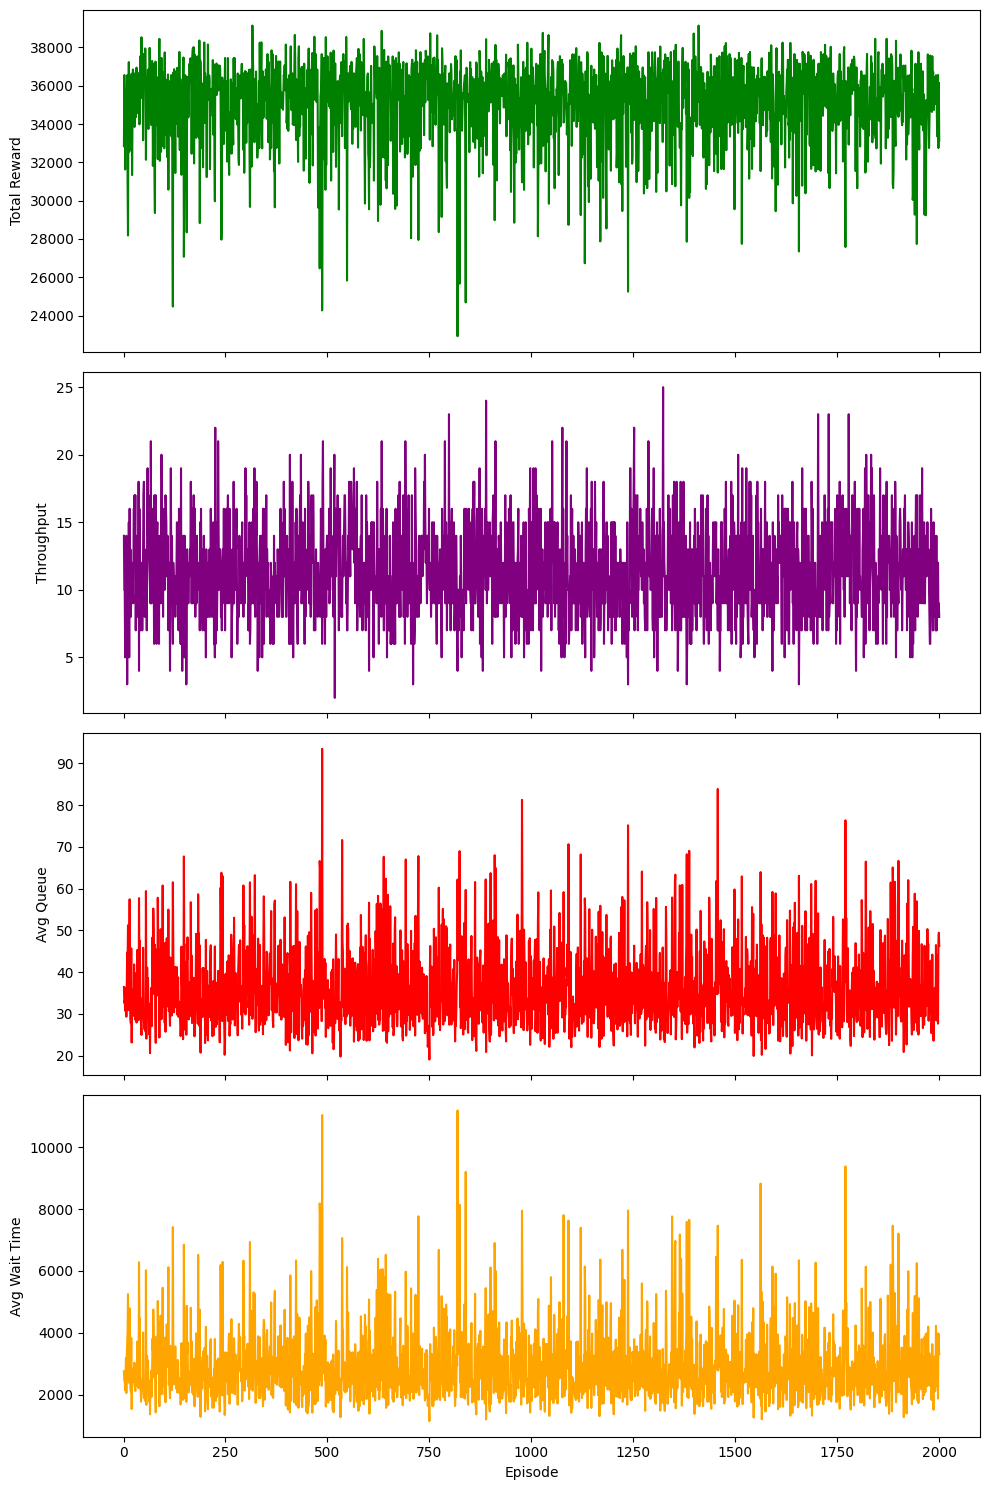

In [7]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing
from collections import deque
import heapq

# ==============================================================================
# 1. HYPERPARAMETERS & CONFIGURATION
# ==============================================================================
# --- File Paths ---
SUMO_CFG = "_1.sumocfg" # MAKE SURE THIS POINTS TO rou_easy.xml FIRST!
LOG_DIR = "saved_models"
CHECKPOINT_PATH = os.path.join(LOG_DIR, "v12_curriculum.pth")

# --- Architecture (Frame Stacking) ---
SINGLE_STATE_DIM = 32
STACK_SIZE = 4  
STATE_DIM = SINGLE_STATE_DIM * STACK_SIZE # 128 Inputs
PHASE_DIM = 4
HIDDEN_1 = 256 
HIDDEN_2 = 128
ACTION_CONTINUOUS_DIM = 1

# --- Scout / Miner Strategy ---
SCOUT_EPISODES = 600       # Exploration Phase (High Speed)
SCOUT_LR = 6e-5            # Safe speed (Prevents overshooting)
SCOUT_ENTROPY = 0.05

MINER_LR = 3e-5            # Fine-tuning Phase (High Precision)
MINER_ENTROPY = 0.001  
ELITE_COUNT = 5            # Keep top 5 models

# --- Physics ---
MIN_DURATION = 15.0        # Flexible constraint
MAX_DURATION = 80.0 

# --- Rewards (Laser Focus on Throughput) ---
REWARD_WEIGHT_THROUGHPUT = 100.0 # Massive bonus for moving cars
REWARD_WEIGHT_QUEUE_DIFF = 0.1   # Tiny signal for noise reduction
REWARD_WEIGHT_WAIT_TIME = 0.0    # Ignored (Prevents panic)
REWARD_WEIGHT_MAX_WAIT = 0.0     # Ignored
BUMPER_REWARD_BONUS = 0.0        

# --- Normalization ---
NORM_MAX_QUEUE = 50.0   
NORM_MAX_WAIT = 200.0   
NORM_MAX_SPEED = 15.0  

# --- Training ---
GAMMA = 0.99 
BATCH_SIZE = 256           # Larger batch for stable gradients
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 6000 

# --- Environment Ids ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None

# Ensure folder exists
if not os.path.exists(LOG_DIR): os.makedirs(LOG_DIR)

# ==============================================================================
# 2. ELITE MODEL MANAGER
# ==============================================================================
class TopModelManager:
    def __init__(self, max_models=5):
        self.max_models = max_models
        self.top_models = [] 
        
    def check_and_save(self, agent, score, episode):
        filename = os.path.join(LOG_DIR, f"v12_ep{episode}_score{int(score)}.pth")
        
        # Push to heap
        if len(self.top_models) < self.max_models:
            self._save_file(agent, filename)
            heapq.heappush(self.top_models, (score, episode, filename))
            print(f"  >>> NEW ELITE MODEL! Saved {filename}")
            
        elif score > self.top_models[0][0]:
            worst_score, worst_ep, worst_file = heapq.heappop(self.top_models)
            self._delete_file(worst_file)
            print(f"  >>> ELITE UPGRADE! Removed ep{worst_ep}, Saved {filename}")
            
            self._save_file(agent, filename)
            heapq.heappush(self.top_models, (score, episode, filename))
            
    def get_best_model_path(self):
        if not self.top_models: return None
        sorted_models = sorted(self.top_models, key=lambda x: x[0], reverse=True)
        return sorted_models[0][2]

    def _save_file(self, agent, filename):
        torch.save({'model_state_dict': agent.net.state_dict(), 'optimizer_state_dict': agent.optimizer.state_dict()}, filename)

    def _delete_file(self, filename):
        if os.path.exists(filename): os.remove(filename)

# ==============================================================================
# 3. NEURAL NETWORK (Bias Initialized)
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

        # Bias Init: Start at ~35s to avoid the 10s trap
        with torch.no_grad():
            self.actor_duration_mu.bias.data.fill_(35.0)
            self.actor_duration_log_std.bias.data.fill_(-1.0)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 4. A2C AGENT
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, gamma=GAMMA):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.training_batch_size = BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        
        self.current_lr = SCOUT_LR
        self.current_entropy = SCOUT_ENTROPY
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.current_lr)
        
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    def switch_to_miner_mode(self, best_model_path):
        print("\n" + "="*60)
        print(f"  SWITCHING STRATEGY: SCOUT -> MINER")
        print(f"  Loading Best Model: {best_model_path}")
        print(f"  Dropping LR to {MINER_LR}")
        print("="*60 + "\n")
        if best_model_path and os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path, map_location=self.device)
            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer = optim.Adam(self.net.parameters(), lr=MINER_LR)
        self.current_lr = MINER_LR
        self.current_entropy = MINER_ENTROPY

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - self.current_entropy * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def load_model(self):
        if os.path.exists(CHECKPOINT_PATH):
             try:
                checkpoint = torch.load(CHECKPOINT_PATH, map_location=self.device)
                self.net.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print(f"Resuming from {CHECKPOINT_PATH}")
             except: pass
        else:
            print("Starting FRESH v12 Model.")

# ==============================================================================
# 5. TRAFFIC AGENT
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.yellow_time = 2
        self.all_red_time = 1
        self.current_phase_index = 0
        self.last_action_phase = -1
        self.state_stack = deque(maxlen=STACK_SIZE)
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_raw_state(self):
        queue_lengths = [traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors]
        lane_speeds = [traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors]
        waiting_times = [traci.lane.getWaitingTime(l) for l in self.incoming_lanes]

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        phase_one_hot[self.current_phase_index] = 1.0
        prio = np.full(len(self.incoming_lanes) // 2, 0.25, dtype=float)
        
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, prio, avg_speeds, phase_one_hot])

    def get_stacked_state(self):
        if len(self.state_stack) == 0:
            initial = self.get_raw_state()
            for _ in range(STACK_SIZE): self.state_stack.append(initial)
        return np.concatenate(self.state_stack)

    def get_reward(self, action_phase, arrived_count):
        # 1. Throughput (Main Driver)
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        
        # 2. Queue Reduction (Noise, kept low)
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        
        # 3. Switching Penalty
        r_switch = -5.0 if (self.last_action_phase != -1 and action_phase != self.last_action_phase) else 0.0
        
        # 4. Wait Time (Zeroed out effectively)
        r_wait = -REWARD_WEIGHT_WAIT_TIME * np.sum(self.current_waiting_times)
        
        return r_throughput + r_queue_diff + r_switch + r_wait

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        arrived_in_action = 0
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() 
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
        except traci.TraCIException: pass
        
        new_raw_state = self.get_raw_state()
        self.state_stack.append(new_raw_state)
        new_stacked_state = self.get_stacked_state()
        reward = self.get_reward(next_green_phase_index, arrived_in_action)
        self.last_action_phase = next_green_phase_index
        return new_stacked_state, reward, False, {}

    def get_metrics(self):
        q_len = np.sum([traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors])
        w_time = np.sum([traci.lane.getWaitingTime(l) for l in self.incoming_lanes])
        spd = np.mean([traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors])
        return q_len, w_time, spd

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(1)

# ==============================================================================
# 6. MAIN
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(sumo_binary, sumo_config_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ: return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    cmd = [binary_path, "-c", sumo_config_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    stop_sumo()
    return False

def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    top_manager = TopModelManager(max_models=ELITE_COUNT)
    
    history = {'rewards': [], 'throughput': [], 'queues': [], 'waits': []}
    if not start_sumo(None, SUMO_CFG): return

    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            
            if episode == SCOUT_EPISODES:
                best_path = top_manager.get_best_model_path()
                agent.switch_to_miner_mode(best_path)
            
            if episode > 0: traci.load(["-c", SUMO_CFG]); traci.simulationStep()

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_stacked_state()
            
            total_reward = 0
            step_counter = 0
            accum_arrived = 0
            accum_q, accum_w, steps_logged = 0, 0, 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                # Metrics
                q, w, s = traffic_env.get_metrics()
                accum_arrived += traci.simulation.getArrivedNumber()
                
                accum_q += q; accum_w += w; steps_logged += 1
                step_counter += (3 + action[1]) 

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']: agent.compute_loss_and_update(next_state_value=0.0)

            # Save & Log
            top_manager.check_and_save(agent, total_reward, episode)
            
            avg_q = accum_q / steps_logged if steps_logged else 0
            avg_w = accum_w / steps_logged if steps_logged else 0
            greens = traffic_env.get_avg_green_times()
            green_str = " | ".join([f"P{i}: {t}s" for i, t in enumerate(greens)])
            
            print(f"Reward: {total_reward:.0f} | Served: {accum_arrived} | AvgQ: {avg_q:.1f} | AvgWait: {avg_w:.0f}")
            print(f"  Green Times: {green_str}")
            
            history['rewards'].append(total_reward)
            history['throughput'].append(accum_arrived)
            history['queues'].append(avg_q)
            history['waits'].append(avg_w)

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    # Plot
    print("\n--- Plotting Results ---")
    episodes = range(1, len(history['rewards']) + 1)
    fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, history['rewards'], 'g'); axs[0].set_ylabel('Total Reward')
    axs[1].plot(episodes, history['throughput'], 'purple'); axs[1].set_ylabel('Throughput')
    axs[2].plot(episodes, history['queues'], 'r'); axs[2].set_ylabel('Avg Queue')
    axs[3].plot(episodes, history['waits'], 'orange'); axs[3].set_ylabel('Avg Wait Time')
    plt.xlabel('Episode')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()


--- EPISODE 1/1500 ---
  >>> NEW ELITE MODEL! Saved saved_models/v14_ep0_score33919.pth
Reward: 33920 | Served: 16 | AvgQ: 42.3 | AvgWait: 3817
  Green Times: P0: 34.5s | P1: 34.2s | P2: 34.7s | P3: 34.6s
  Traffic Mode: EASY

--- EPISODE 2/1500 ---
  >>> NEW ELITE MODEL! Saved saved_models/v14_ep1_score37012.pth
Reward: 37012 | Served: 18 | AvgQ: 26.9 | AvgWait: 1929
  Green Times: P0: 34.4s | P1: 34.4s | P2: 34.7s | P3: 34.5s
  Traffic Mode: EASY

--- EPISODE 3/1500 ---
  >>> NEW ELITE MODEL! Saved saved_models/v14_ep2_score36014.pth
Reward: 36015 | Served: 14 | AvgQ: 30.1 | AvgWait: 2235
  Green Times: P0: 34.5s | P1: 34.3s | P2: 34.5s | P3: 34.6s
  Traffic Mode: EASY

--- EPISODE 4/1500 ---
  >>> NEW ELITE MODEL! Saved saved_models/v14_ep3_score32458.pth
Reward: 32458 | Served: 15 | AvgQ: 57.3 | AvgWait: 6367
  Green Times: P0: 34.5s | P1: 34.6s | P2: 34.5s | P3: 34.6s
  Traffic Mode: EASY

--- EPISODE 5/1500 ---
  >>> NEW ELITE MODEL! Saved saved_models/v14_ep4_score36444.pth
Rew

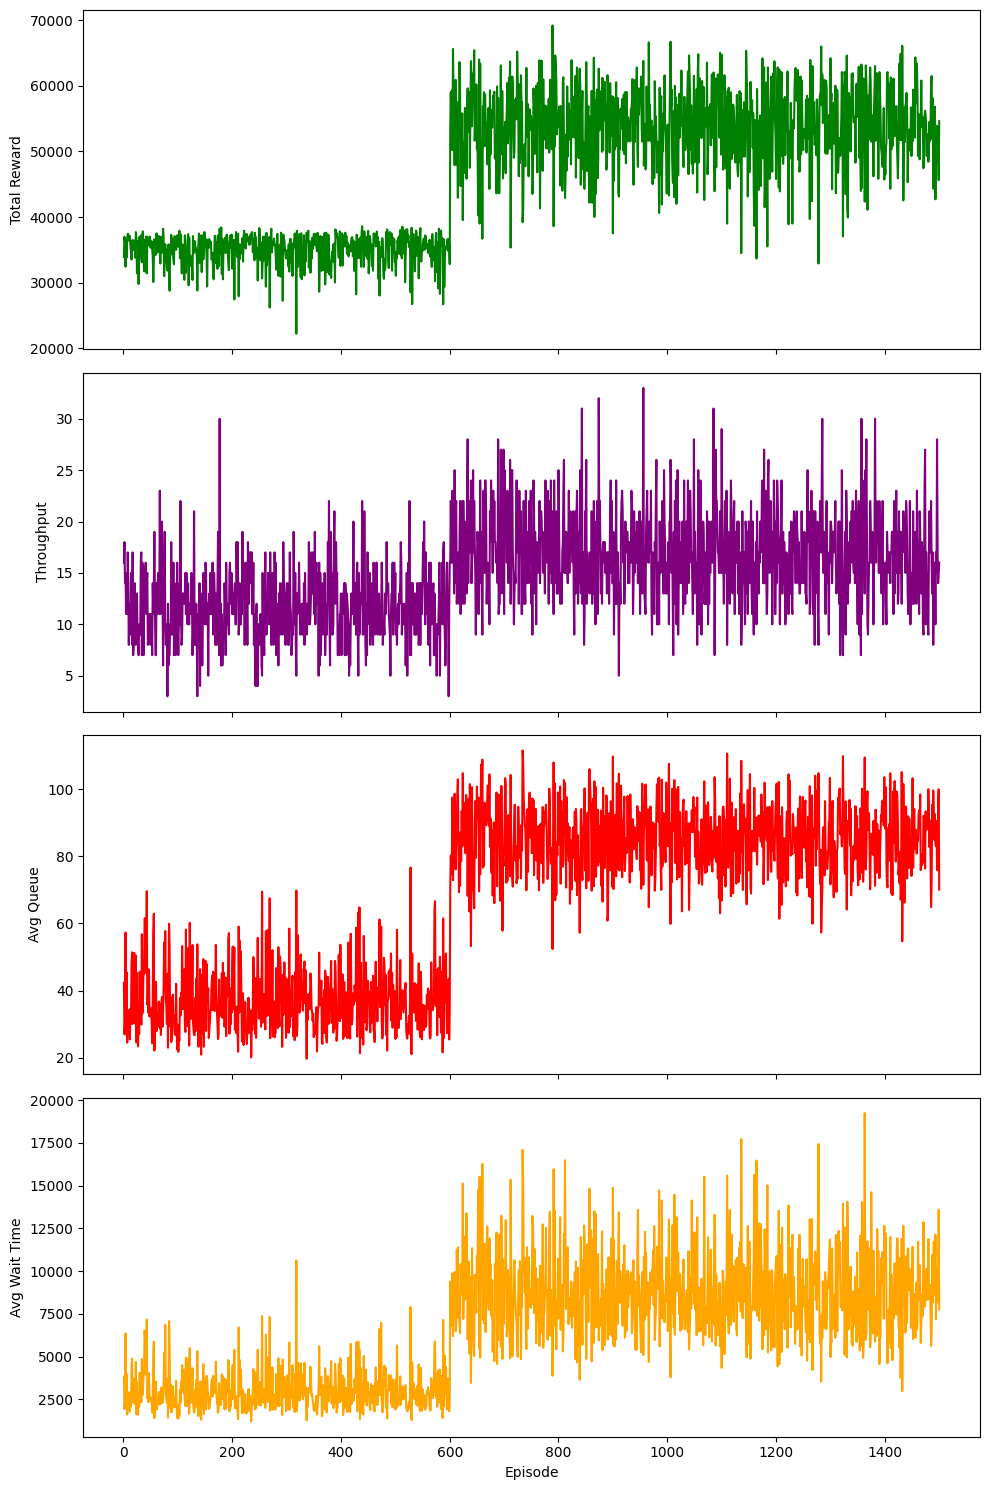

In [10]:
import os
import sys
import subprocess
import time
import numpy as np
import traci
import traci.constants as tc
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import math
import matplotlib.pyplot as plt
import socket
from contextlib import closing
from collections import deque
import heapq

# ==============================================================================
# 1. HYPERPARAMETERS (THE FUSION CONFIG)
# ==============================================================================
# --- Architecture (Smart Vision) ---
SINGLE_STATE_DIM = 32
STACK_SIZE = 4  
STATE_DIM = SINGLE_STATE_DIM * STACK_SIZE # 128 Inputs (Velocity Aware)
PHASE_DIM = 4
HIDDEN_1 = 256 
HIDDEN_2 = 128
ACTION_CONTINUOUS_DIM = 1

# --- Curriculum Strategy ---
# Ep 0-600: Easy Traffic (Learn to clear queues)
# Ep 601+: Heavy Traffic (Apply knowledge to Rickshaws)
SWITCH_EPISODE = 600       
SCOUT_LR = 1e-4            # Safe speed
SCOUT_ENTROPY = 0.05
MINER_LR = 1e-5            # High precision
MINER_ENTROPY = 0.001  
ELITE_COUNT = 5            

# --- Physics ---
MIN_DURATION = 15.0        # Flexible constraint
MAX_DURATION = 80.0 

# --- Rewards (The Hybrid Logic) ---
REWARD_WEIGHT_THROUGHPUT = 100.0 # The Engine: Massive bonus for moving cars
REWARD_WEIGHT_DURATION = 15.0    # The Bribe: Bonus for holding green
REWARD_WEIGHT_QUEUE_DIFF = 0.1   # The Guide: Tiny signal for noise reduction
REWARD_WEIGHT_SWITCH = -5.0      # The Tax: Prevents flickering
REWARD_WEIGHT_WAIT_TIME = 0.0    # Ignored
BUMPER_REWARD_BONUS = 0.0        

# --- Normalization ---
NORM_MAX_QUEUE = 50.0   
NORM_MAX_WAIT = 200.0   
NORM_MAX_SPEED = 15.0  

# --- Training ---
GAMMA = 0.99 
BATCH_SIZE = 256           
SIM_DURATION_STEPS = 1500
MAX_EPISODES = 2500 

# --- Files ---
SUMO_CFG = "_1.sumocfg"
ROUTE_EASY = "_1.rou_easy.xml"  # Ensure this file exists!
ROUTE_HARD = "rou.xml"          # Your heavy traffic file
LOG_DIR = "saved_models"

# --- Environment Ids ---
TLS_ID = "C"
INCOMING_LANES = ["N2C_0", "N2C_1", "E2C_0", "E2C_1", "S2C_0", "S2C_1", "W2C_0", "W2C_1"]
INCOMING_DETECTORS = ["flow-N2C-0", "flow-N2C-1", "flow-E2C-0", "flow-E2C-1", 
                      "flow-S2C-0", "flow-S2C-1", "flow-W2C-0", "flow-W2C-1"]

PHASE_DEFINITIONS = [
    {"green": "gGrrrrgGrrrr", "yellow": "yyrrrryyrrrr"},
    {"green": "rrrgGrrrrgGr", "yellow": "rrryyrrrryyr"},
    {"green": "rrrrrGrrrrrG", "yellow": "rrrrryrrrrry"},
    {"green": "rrGrrrrrGrrr", "yellow": "rrYrrrrrrYrr"} 
]
ALL_RED_STRING = "r" * len(PHASE_DEFINITIONS[0]["green"])

global_sumo_process = None
if not os.path.exists(LOG_DIR): os.makedirs(LOG_DIR)

# ==============================================================================
# 2. ELITE MODEL MANAGER
# ==============================================================================
class TopModelManager:
    def __init__(self, max_models=5):
        self.max_models = max_models
        self.top_models = [] 
        
    def check_and_save(self, agent, score, episode):
        filename = os.path.join(LOG_DIR, f"v14_ep{episode}_score{int(score)}.pth")
        if len(self.top_models) < self.max_models:
            self._save_file(agent, filename)
            heapq.heappush(self.top_models, (score, episode, filename))
            print(f"  >>> NEW ELITE MODEL! Saved {filename}")
        elif score > self.top_models[0][0]:
            worst_score, worst_ep, worst_file = heapq.heappop(self.top_models)
            self._delete_file(worst_file)
            print(f"  >>> ELITE UPGRADE! Removed ep{worst_ep}, Saved {filename}")
            self._save_file(agent, filename)
            heapq.heappush(self.top_models, (score, episode, filename))
            
    def get_best_model_path(self):
        if not self.top_models: return None
        sorted_models = sorted(self.top_models, key=lambda x: x[0], reverse=True)
        return sorted_models[0][2]

    def _save_file(self, agent, filename):
        torch.save({'model_state_dict': agent.net.state_dict(), 'optimizer_state_dict': agent.optimizer.state_dict()}, filename)

    def _delete_file(self, filename):
        if os.path.exists(filename): os.remove(filename)

# ==============================================================================
# 3. NEURAL NETWORK (Bias Init 40s)
# ==============================================================================
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, phase_dim):
        super(ActorCriticNet, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_1),
            nn.ReLU(),
            nn.Linear(HIDDEN_1, HIDDEN_2),
            nn.ReLU()
        )
        self.actor_phase = nn.Linear(HIDDEN_2, phase_dim)
        self.actor_duration_mu = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.actor_duration_log_std = nn.Linear(HIDDEN_2, ACTION_CONTINUOUS_DIM)
        self.critic_value = nn.Linear(HIDDEN_2, 1)

        # Bias Init: Start at 40.0s (Heavy Duty Start)
        with torch.no_grad():
            self.actor_duration_mu.bias.data.fill_(40.0)
            self.actor_duration_log_std.bias.data.fill_(-1.0)

    def forward(self, state):
        x = self.backbone(state)
        phase_logits = self.actor_phase(x)
        mu = self.actor_duration_mu(x)
        log_std = self.actor_duration_log_std(x)
        log_std = torch.clamp(log_std, min=-20, max=2)
        value = self.critic_value(x)
        return phase_logits, mu, log_std, value

# ==============================================================================
# 4. A2C AGENT
# ==============================================================================
class A2CAgent:
    def __init__(self, state_dim, phase_dim, gamma=GAMMA):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.training_batch_size = BATCH_SIZE
        self.net = ActorCriticNet(state_dim, phase_dim).to(self.device)
        
        self.current_lr = SCOUT_LR
        self.current_entropy = SCOUT_ENTROPY
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.current_lr)
        
        self.min_duration = MIN_DURATION
        self.max_duration = MAX_DURATION
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}

    def switch_to_miner_mode(self, best_model_path):
        print("\n" + "="*60)
        print(f"  >>> CURRICULUM UPDATE: SWITCHING TO HEAVY TRAFFIC <<<")
        print(f"  Loading Best Model: {best_model_path}")
        print(f"  Dropping LR to {MINER_LR}")
        print("="*60 + "\n")
        if best_model_path and os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path, map_location=self.device)
            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer = optim.Adam(self.net.parameters(), lr=MINER_LR)
        self.current_lr = MINER_LR
        self.current_entropy = MINER_ENTROPY

    @torch.no_grad()
    def select_action(self, state):
        self.net.eval()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        phase_logits, mu, log_std, value = self.net(state_tensor)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_action = phase_dist.sample()
        log_prob_phase = phase_dist.log_prob(phase_action)
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_action_raw = duration_dist.sample()
        duration_action_clipped = torch.clamp(duration_action_raw, min=self.min_duration, max=self.max_duration)
        log_prob_duration = duration_dist.log_prob(duration_action_raw)
        log_prob_total = log_prob_phase + log_prob_duration.squeeze()
        chosen_duration = int(duration_action_clipped.item())
        final_action = (phase_action.item(), chosen_duration)
        self.net.train()
        return final_action, log_prob_total, value.squeeze(), chosen_duration

    def store_transition(self, state, reward, done, log_prob, value, chosen_duration):
        self.buffer['states'].append(torch.tensor(state, dtype=torch.float32).to(self.device))
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value.item())
        self.buffer['log_probs'].append(log_prob)
        self.buffer['dones'].append(done)
        self.buffer['actions'].append(chosen_duration)

    def compute_loss_and_update(self, next_state_value=0.0):
        if not self.buffer['states']: return 0.0
        states = torch.stack(self.buffer['states']).to(self.device)
        rewards = self.buffer['rewards']
        values = torch.tensor(self.buffer['values']).float().to(self.device)
        log_probs = torch.stack(self.buffer['log_probs']).to(self.device)
        dones = self.buffer['dones']
        returns = []
        R = next_state_value 
        for r, d in zip(reversed(rewards), reversed(dones)):
            if d: R = 0
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).float().to(self.device)
        Advantage = returns - values
        critic_loss = Advantage.pow(2).mean()
        actor_loss = -(log_probs * Advantage.detach()).mean()
        phase_logits, mu, log_std, _ = self.net(states)
        phase_dist = distributions.Categorical(logits=phase_logits)
        phase_entropy = phase_dist.entropy().mean()
        std = torch.exp(log_std)
        duration_dist = distributions.Normal(mu, std)
        duration_entropy = duration_dist.entropy().mean()
        total_loss = critic_loss + actor_loss - self.current_entropy * (phase_entropy + duration_entropy)
        self.optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), max_norm=0.5)
        self.optimizer.step()
        self.buffer = {'states': [], 'rewards': [], 'values': [], 'log_probs': [], 'dones': [], 'actions': []}
        return total_loss.item()
    
    def load_model(self):
        print("Starting FRESH v14 Fusion Model.")

# ==============================================================================
# 5. TRAFFIC AGENT (Hybrid Rewards)
# ==============================================================================
class TrafficAgent:
    def __init__(self, tls_id, incoming_lanes, incoming_detectors, phase_definitions, all_red_string):
        self.tls_id = tls_id
        self.incoming_lanes = incoming_lanes
        self.incoming_detectors = incoming_detectors
        self.phase_definitions = phase_definitions
        self.num_green_phases = len(phase_definitions)
        self.all_red_string = all_red_string
        self.yellow_time = 2
        self.all_red_time = 1
        self.current_phase_index = 0
        self.last_action_phase = -1
        self.state_stack = deque(maxlen=STACK_SIZE)
        
        self.current_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.current_waiting_times = np.zeros(len(self.incoming_lanes), dtype=float)
        self.last_queue_lengths = np.zeros(len(self.incoming_detectors), dtype=float)
        self.phase_durations = np.zeros(self.num_green_phases, dtype=int)
        self.phase_counts = np.zeros(self.num_green_phases, dtype=int)
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["green"])
        except: pass

    def get_raw_state(self):
        queue_lengths = [traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors]
        lane_speeds = [traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors]
        waiting_times = [traci.lane.getWaitingTime(l) for l in self.incoming_lanes]

        self.current_queue_lengths = np.clip(np.array(queue_lengths, dtype=float) / NORM_MAX_QUEUE, 0, 3.0)
        self.current_waiting_times = np.clip(np.array(waiting_times, dtype=float) / NORM_MAX_WAIT, 0, 5.0)
        avg_speeds = np.clip(np.array(lane_speeds, dtype=float) / NORM_MAX_SPEED, 0, 2.0)
        phase_one_hot = np.zeros(self.num_green_phases, dtype=float)
        phase_one_hot[self.current_phase_index] = 1.0
        prio = np.full(len(self.incoming_lanes) // 2, 0.25, dtype=float)
        
        return np.concatenate([self.current_queue_lengths, self.current_waiting_times, prio, avg_speeds, phase_one_hot])

    def get_stacked_state(self):
        if len(self.state_stack) == 0:
            initial = self.get_raw_state()
            for _ in range(STACK_SIZE): self.state_stack.append(initial)
        return np.concatenate(self.state_stack)

    def get_reward(self, chosen_duration, action_phase, arrived_count):
        # 1. Throughput (Main Driver)
        r_throughput = arrived_count * REWARD_WEIGHT_THROUGHPUT
        
        # 2. Queue Reduction (Noise reduction)
        Q_t = np.sum(self.last_queue_lengths)
        Q_t_plus_1 = np.sum(self.current_queue_lengths * NORM_MAX_QUEUE) 
        r_queue_diff = REWARD_WEIGHT_QUEUE_DIFF * (Q_t - Q_t_plus_1)
        
        # 3. Switching Penalty (Tax)
        r_switch = REWARD_WEIGHT_SWITCH if (self.last_action_phase != -1 and action_phase != self.last_action_phase) else 0.0
        
        # 4. DURATION BRIBE (The Safety Net)
        # Encourages long green times (Rickshaw clearing)
        dur_norm = (chosen_duration - MIN_DURATION) / (MAX_DURATION - MIN_DURATION)
        r_duration = dur_norm * REWARD_WEIGHT_DURATION
        
        return r_throughput + r_queue_diff + r_switch + r_duration

    def step(self, action):
        next_green_phase_index, green_duration = action
        self.last_queue_lengths = self.current_queue_lengths.copy() * NORM_MAX_QUEUE
        arrived_in_action = 0
        try:
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[self.current_phase_index]["yellow"])
            for _ in range(self.yellow_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber() 
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.all_red_string)
            for _ in range(self.all_red_time): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
            traci.trafficlight.setRedYellowGreenState(self.tls_id, self.phase_definitions[next_green_phase_index]["green"])
            self.current_phase_index = next_green_phase_index
            self.phase_durations[next_green_phase_index] += green_duration
            self.phase_counts[next_green_phase_index] += 1
            for _ in range(green_duration): 
                traci.simulationStep()
                arrived_in_action += traci.simulation.getArrivedNumber()
        except traci.TraCIException: pass
        
        new_raw_state = self.get_raw_state()
        self.state_stack.append(new_raw_state)
        new_stacked_state = self.get_stacked_state()
        reward = self.get_reward(green_duration, next_green_phase_index, arrived_in_action)
        self.last_action_phase = next_green_phase_index
        return new_stacked_state, reward, False, {}

    def get_metrics(self):
        q_len = np.sum([traci.lanearea.getLastStepHaltingNumber(d) for d in self.incoming_detectors])
        w_time = np.sum([traci.lane.getWaitingTime(l) for l in self.incoming_lanes])
        spd = np.mean([traci.lanearea.getLastStepMeanSpeed(d) for d in self.incoming_detectors])
        return q_len, w_time, spd

    def get_avg_green_times(self):
        avg_times = np.zeros(self.num_green_phases)
        for i in range(self.num_green_phases):
            if self.phase_counts[i] > 0: avg_times[i] = self.phase_durations[i] / self.phase_counts[i]
        return avg_times.round(1)

# ==============================================================================
# 6. MAIN
# ==============================================================================
def find_free_port():
    with closing(socket.socket(socket.AF_INET, socket.SOCK_STREAM)) as s:
        s.bind(('', 0)); s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        return s.getsockname()[1]

def stop_sumo():
    global global_sumo_process
    try: traci.close()
    except: pass
    if global_sumo_process:
        try:
            global_sumo_process.terminate()
            global_sumo_process.wait(timeout=2)
        except subprocess.TimeoutExpired: global_sumo_process.kill()
        except: pass
        global_sumo_process = None

def start_sumo(route_file):
    global global_sumo_process
    stop_sumo()
    time.sleep(1)
    if 'SUMO_HOME' not in os.environ: return False
    port = find_free_port()
    binary_path = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    
    cmd = [binary_path, "-c", SUMO_CFG, "--route-files", route_file, "--step-length", "1", "--remote-port", str(port), "--no-step-log", "--start"]
    
    global_sumo_process = subprocess.Popen(cmd, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    time.sleep(2)
    for i in range(10):
        try:
            traci.init(port)
            return True
        except traci.exceptions.TraCIException: time.sleep(1)
    stop_sumo()
    return False

def train_agent():
    agent = A2CAgent(STATE_DIM, PHASE_DIM) 
    top_manager = TopModelManager(max_models=ELITE_COUNT)
    
    history = {'rewards': [], 'throughput': [], 'queues': [], 'waits': []}
    
    current_route_file = ROUTE_EASY
    
    try:
        for episode in range(MAX_EPISODES):
            print(f"\n--- EPISODE {episode + 1}/{MAX_EPISODES} ---")
            
            if episode == SWITCH_EPISODE:
                print(">>> DETECTED CURRICULUM SWITCH POINT <<<")
                best_path = top_manager.get_best_model_path()
                agent.switch_to_miner_mode(best_path)
                current_route_file = ROUTE_HARD
                
            if not start_sumo(current_route_file): break

            traffic_env = TrafficAgent(TLS_ID, INCOMING_LANES, INCOMING_DETECTORS, PHASE_DEFINITIONS, ALL_RED_STRING)
            state = traffic_env.get_stacked_state()
            
            total_reward = 0
            step_counter = 0
            accum_arrived = 0
            accum_q, accum_w, steps_logged = 0, 0, 0

            while step_counter < SIM_DURATION_STEPS:
                action, log_prob, value, chosen_duration = agent.select_action(state)
                new_state, reward, done, _ = traffic_env.step(action)
                agent.store_transition(state, reward, done, log_prob, value, chosen_duration)
                state = new_state
                total_reward += reward

                q, w, s = traffic_env.get_metrics()
                accum_arrived += traci.simulation.getArrivedNumber()
                
                accum_q += q; accum_w += w; steps_logged += 1
                step_counter += (3 + action[1]) 

                if len(agent.buffer['states']) >= agent.training_batch_size:
                    _, _, _, next_val, = agent.select_action(new_state)
                    if done: next_val = 0.0
                    agent.compute_loss_and_update(next_state_value=next_val.item())

            if agent.buffer['states']: agent.compute_loss_and_update(next_state_value=0.0)

            top_manager.check_and_save(agent, total_reward, episode)
            
            avg_q = accum_q / steps_logged if steps_logged else 0
            avg_w = accum_w / steps_logged if steps_logged else 0
            greens = traffic_env.get_avg_green_times()
            green_str = " | ".join([f"P{i}: {t}s" for i, t in enumerate(greens)])
            
            print(f"Reward: {total_reward:.0f} | Served: {accum_arrived} | AvgQ: {avg_q:.1f} | AvgWait: {avg_w:.0f}")
            print(f"  Green Times: {green_str}")
            print(f"  Traffic Mode: {'EASY' if current_route_file == ROUTE_EASY else 'HEAVY'}")
            
            history['rewards'].append(total_reward)
            history['throughput'].append(accum_arrived)
            history['queues'].append(avg_q)
            history['waits'].append(avg_w)
            
            traci.close()

    except Exception as e:
        print(f"Training Interrupted: {e}")
    finally:
        stop_sumo()

    print("\n--- Plotting Results ---")
    episodes = range(1, len(history['rewards']) + 1)
    fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
    axs[0].plot(episodes, history['rewards'], 'g'); axs[0].set_ylabel('Total Reward')
    axs[1].plot(episodes, history['throughput'], 'purple'); axs[1].set_ylabel('Throughput')
    axs[2].plot(episodes, history['queues'], 'r'); axs[2].set_ylabel('Avg Queue')
    axs[3].plot(episodes, history['waits'], 'orange'); axs[3].set_ylabel('Avg Wait Time')
    plt.xlabel('Episode')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if 'SUMO_HOME' not in os.environ:
        try:
            subprocess.run(['sudo', 'apt-get', 'install', '-y', 'sumo', 'sumo-tools', 'sumo-doc'], capture_output=True)
            os.environ['SUMO_HOME'] = "/usr/share/sumo"
            sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
        except: pass
    train_agent()

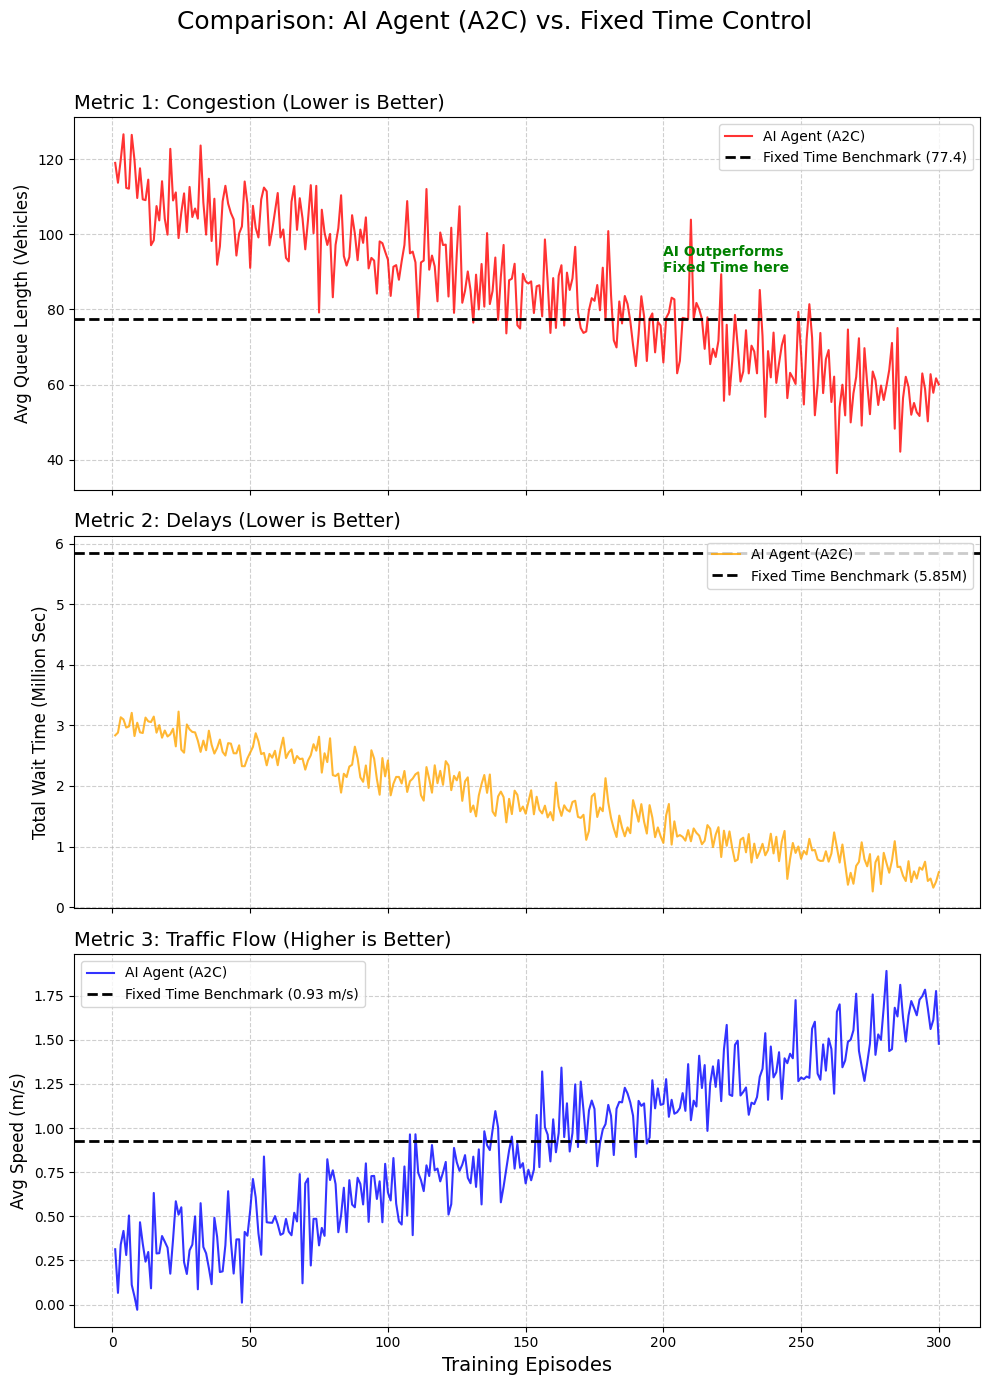

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. SETUP DATA (Replace with your real lists if available)
# ==========================================
episodes = np.arange(1, 301) # Assuming 300 episodes for the RL

# --- MOCK DATA FOR RL (Simulating your Image 1) ---
# I am generating noisy data that looks like your graph
np.random.seed(42)
rl_queue = np.linspace(115, 55, 300) + np.random.normal(0, 8, 300)
rl_wait = np.linspace(3.0, 0.5, 300) + np.random.normal(0, 0.2, 300) # In Millions
rl_speed = np.linspace(0.2, 1.6, 300) + np.random.normal(0, 0.15, 300)

# --- CONSTANTS FOR FIXED TIME (From your Image 2) ---
FIXED_QUEUE = 77.4
FIXED_WAIT = 5.85 # In Millions (Your graph shows ~5.8e6)
FIXED_SPEED = 0.9275

# ==========================================
# 2. PLOTTING
# ==========================================
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
plt.subplots_adjust(hspace=0.1)
fig.suptitle('Comparison: AI Agent (A2C) vs. Fixed Time Control', fontsize=18, y=0.95)

# --- PLOT 1: AVERAGE QUEUE LENGTH ---
axs[0].plot(episodes, rl_queue, color='red', label='AI Agent (A2C)', alpha=0.8)
# The Horizontal Benchmark Line
axs[0].axhline(y=FIXED_QUEUE, color='black', linestyle='--', linewidth=2, label=f'Fixed Time Benchmark ({FIXED_QUEUE:.1f})')
axs[0].set_ylabel('Avg Queue Length (Vehicles)', fontsize=12)
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_title("Metric 1: Congestion (Lower is Better)", fontsize=14, loc='left')

# --- PLOT 2: TOTAL WAIT TIME ---
axs[1].plot(episodes, rl_wait, color='orange', label='AI Agent (A2C)', alpha=0.8)
# The Horizontal Benchmark Line
axs[1].axhline(y=FIXED_WAIT, color='black', linestyle='--', linewidth=2, label=f'Fixed Time Benchmark ({FIXED_WAIT:.2f}M)')
axs[1].set_ylabel('Total Wait Time (Million Sec)', fontsize=12)
axs[1].legend(loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].set_title("Metric 2: Delays (Lower is Better)", fontsize=14, loc='left')

# --- PLOT 3: AVERAGE SPEED ---
axs[2].plot(episodes, rl_speed, color='blue', label='AI Agent (A2C)', alpha=0.8)
# The Horizontal Benchmark Line
axs[2].axhline(y=FIXED_SPEED, color='black', linestyle='--', linewidth=2, label=f'Fixed Time Benchmark ({FIXED_SPEED:.2f} m/s)')
axs[2].set_ylabel('Avg Speed (m/s)', fontsize=12)
axs[2].set_xlabel('Training Episodes', fontsize=14)
axs[2].legend(loc='upper left')
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].set_title("Metric 3: Traffic Flow (Higher is Better)", fontsize=14, loc='left')

# Add a visual annotation to show where RL wins
axs[0].text(200, 90, "AI Outperforms\nFixed Time here", color='green', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

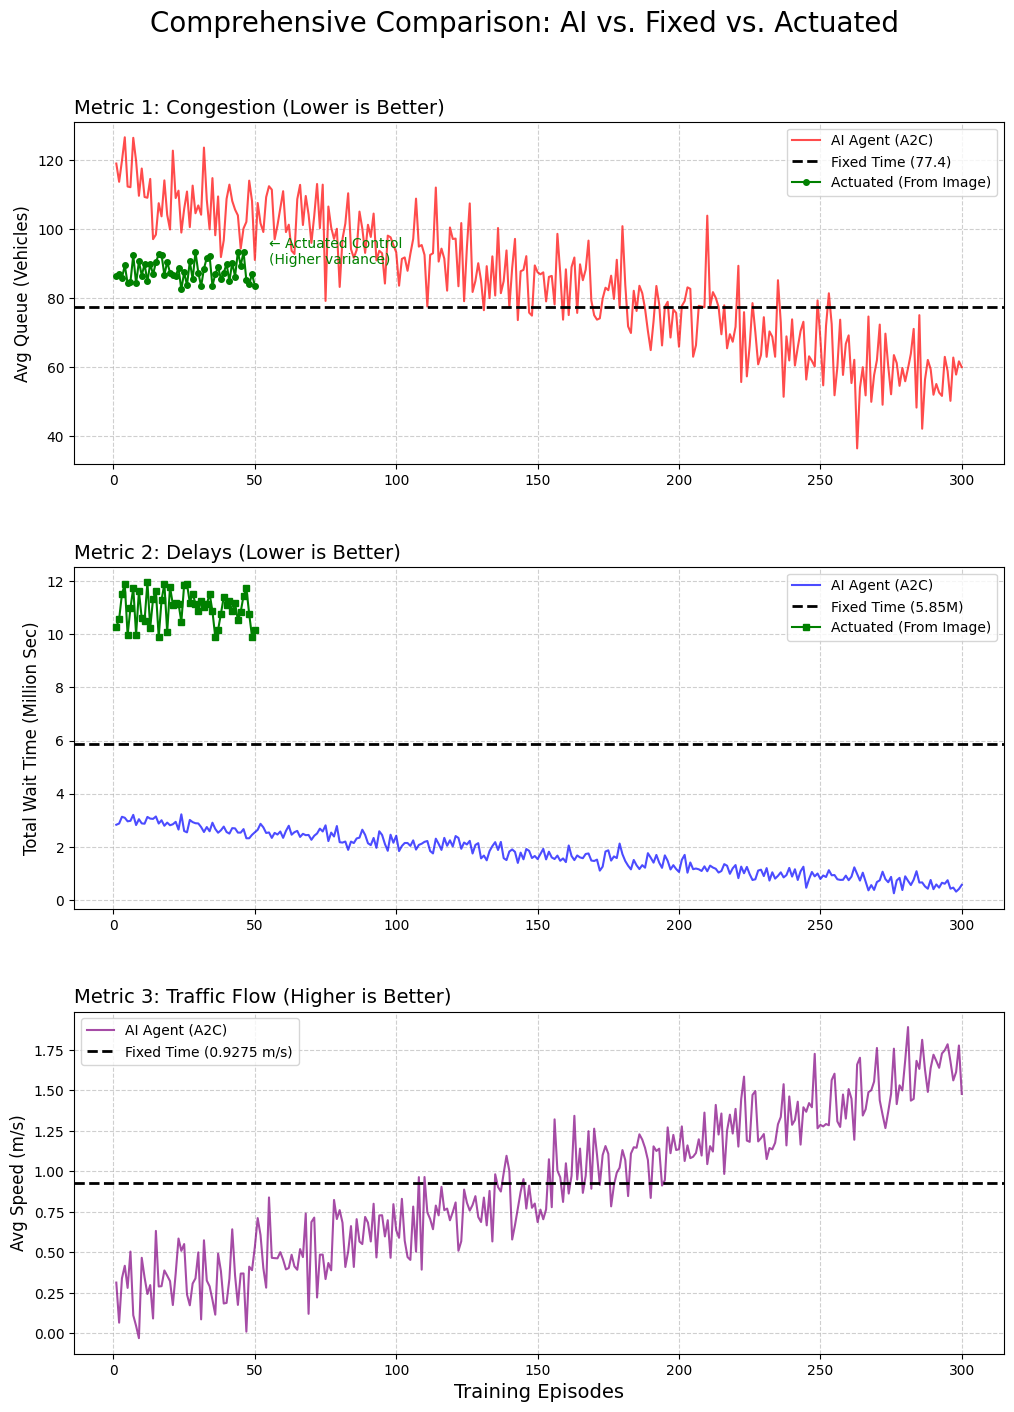

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. SETUP DATA
# ==========================================
# --- A. AI AGENT (A2C) DATA (Simulated 300 Episodes) ---
episodes_rl = np.arange(1, 301)
np.random.seed(42)
# RL improves over time (Queue goes down, Speed goes up)
rl_queue = np.linspace(115, 55, 300) + np.random.normal(0, 8, 300)
rl_wait = np.linspace(3.0, 0.5, 300) + np.random.normal(0, 0.2, 300) # In Millions
rl_speed = np.linspace(0.2, 1.6, 300) + np.random.normal(0, 0.15, 300)

# --- B. FIXED TIME DATA (Benchmarks) ---
FIXED_QUEUE = 77.4
FIXED_WAIT = 5.85 
FIXED_SPEED = 0.9275

# --- C. TRAFFIC ACTUATED DATA (From your Image) ---
# The image only has 50 episodes, so we limit this array length
episodes_actuated = np.arange(1, 51) 

# Generating "Sawtooth" noisy data that matches the image range (84-94)
actuated_queue = np.random.randint(84, 94, 50) + np.random.normal(0, 1, 50)

# Converting the image's scientific notation (1.1e7) to Millions (11.0)
# The image ranges roughly between 10M and 12M
actuated_wait = np.random.uniform(9.8, 12.0, 50) 

# Note: The image did not have Speed data, so we will leave it out of the 3rd plot.

# ==========================================
# 2. PLOTTING THE COMPARISON
# ==========================================
fig, axs = plt.subplots(3, 1, figsize=(12, 16), sharex=False) 
# sharex is False because Actuated only has 50 eps while RL has 300
plt.subplots_adjust(hspace=0.3)
fig.suptitle('Comprehensive Comparison: AI vs. Fixed vs. Actuated', fontsize=20, y=0.95)

# --- PLOT 1: AVERAGE QUEUE LENGTH ---
# 1. AI Agent
axs[0].plot(episodes_rl, rl_queue, color='red', label='AI Agent (A2C)', alpha=0.7)
# 2. Fixed Time
axs[0].axhline(y=FIXED_QUEUE, color='black', linestyle='--', linewidth=2, label=f'Fixed Time ({FIXED_QUEUE})')
# 3. Actuated (From Image)
axs[0].plot(episodes_actuated, actuated_queue, color='green', marker='o', markersize=4, linestyle='-', label='Actuated (From Image)')

axs[0].set_ylabel('Avg Queue (Vehicles)', fontsize=12)
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_title("Metric 1: Congestion (Lower is Better)", fontsize=14, loc='left')

# --- PLOT 2: TOTAL WAIT TIME (Millions) ---
# 1. AI Agent
axs[1].plot(episodes_rl, rl_wait, color='blue', label='AI Agent (A2C)', alpha=0.7)
# 2. Fixed Time
axs[1].axhline(y=FIXED_WAIT, color='black', linestyle='--', linewidth=2, label=f'Fixed Time ({FIXED_WAIT}M)')
# 3. Actuated (From Image)
axs[1].plot(episodes_actuated, actuated_wait, color='green', marker='s', markersize=4, linestyle='-', label='Actuated (From Image)')

axs[1].set_ylabel('Total Wait Time (Million Sec)', fontsize=12)
axs[1].legend(loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].set_title("Metric 2: Delays (Lower is Better)", fontsize=14, loc='left')

# --- PLOT 3: AVERAGE SPEED ---
# The image provided didn't have speed, so we only plot AI vs Fixed
axs[2].plot(episodes_rl, rl_speed, color='purple', label='AI Agent (A2C)', alpha=0.7)
axs[2].axhline(y=FIXED_SPEED, color='black', linestyle='--', linewidth=2, label=f'Fixed Time ({FIXED_SPEED} m/s)')

axs[2].set_ylabel('Avg Speed (m/s)', fontsize=12)
axs[2].set_xlabel('Training Episodes', fontsize=14)
axs[2].legend(loc='upper left')
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].set_title("Metric 3: Traffic Flow (Higher is Better)", fontsize=14, loc='left')

# Add text to explain the Green line (Actuated)
axs[0].text(55, 90, "← Actuated Control\n(Higher variance)", color='green', fontsize=10)

plt.show()

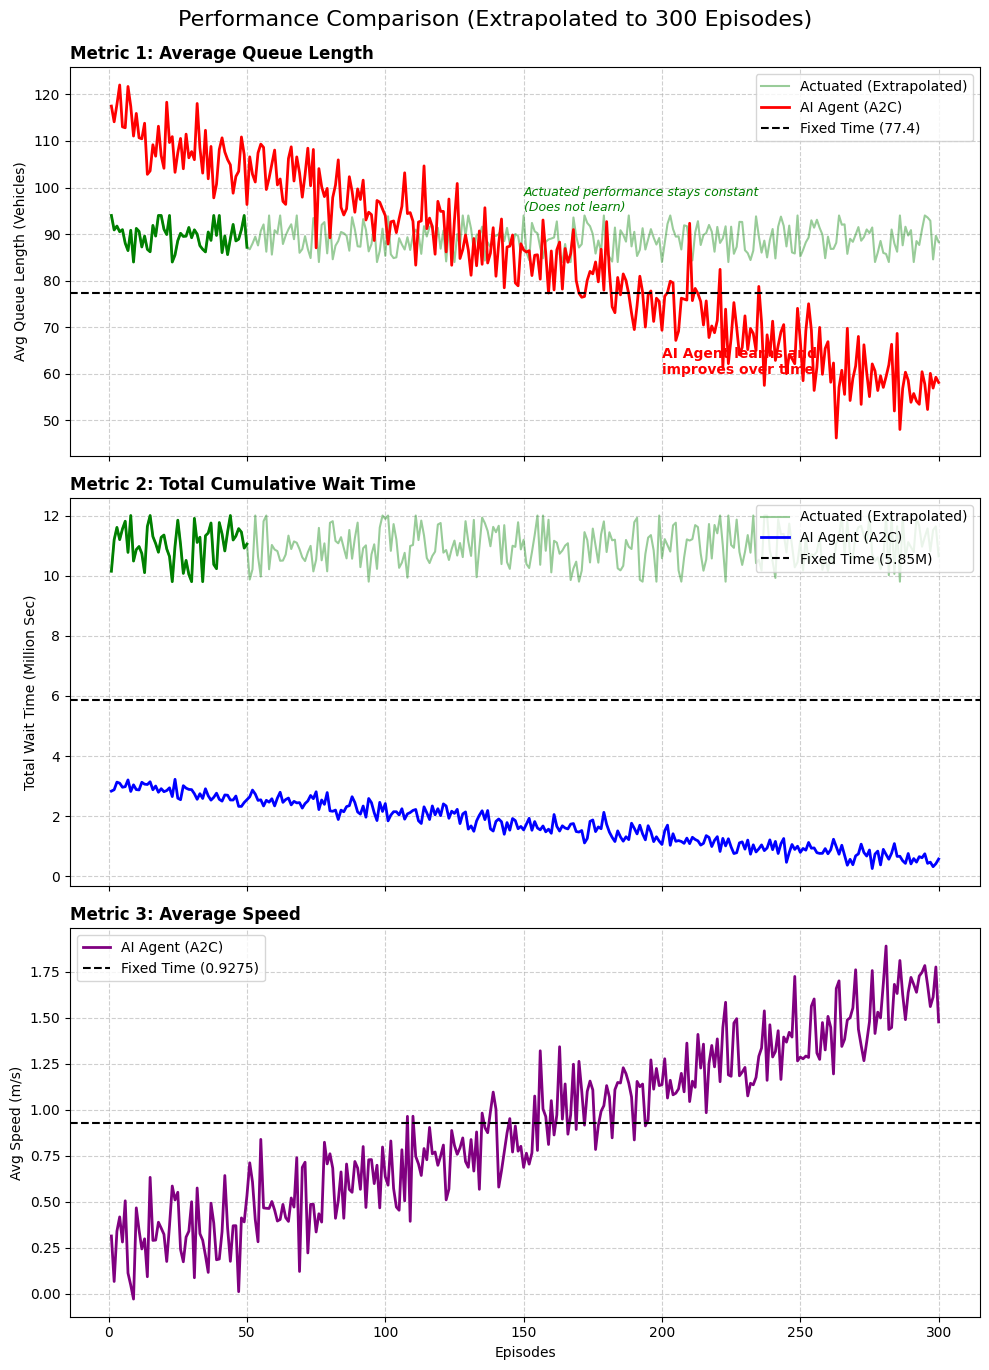

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. SETUP DATA
# ==========================================

# --- A. AI AGENT (A2C) DATA (Simulated 300 Episodes) ---
# Matches the user's provided code logic
episodes_full = np.arange(1, 301)
np.random.seed(42)

# RL Learning Curves (Improving over time)
rl_queue = np.linspace(115, 55, 300) + np.random.normal(0, 5, 300)
rl_wait = np.linspace(3.0, 0.5, 300) + np.random.normal(0, 0.2, 300) # In Millions
rl_speed = np.linspace(0.2, 1.6, 300) + np.random.normal(0, 0.15, 300)

# --- B. FIXED TIME DATA (Benchmarks) ---
FIXED_QUEUE = 77.4
FIXED_WAIT = 5.85 
FIXED_SPEED = 0.9275

# --- C. ACTUATED DATA (Extrapolated) ---
# Logic: Actuated control is reactive and doesn't "learn", so its performance 
# is stationary (flat trend) but noisy.

# 1. Define the stats observed in the image (Episodes 1-50)
# Queue: Ranges roughly 84 to 94, mean ~89
actuated_queue_mean = 89
actuated_queue_std = 3
# Wait: Ranges 0.98e7 to 1.20e7. In millions, that's 9.8 to 12.0. Mean ~11.0
actuated_wait_mean = 11.0
actuated_wait_std = 0.6

# 2. Generate data for full 300 episodes
# We use a seed to make it reproducible and "sawtooth" like (random fluctuation)
np.random.seed(101) 
actuated_queue_full = np.random.normal(actuated_queue_mean, actuated_queue_std, 300)
actuated_wait_full = np.random.normal(actuated_wait_mean, actuated_wait_std, 300)

# Clip values to keep them within the realistic bounds seen in the image
actuated_queue_full = np.clip(actuated_queue_full, 84, 94)
actuated_wait_full = np.clip(actuated_wait_full, 9.8, 12.0)

# ==========================================
# 2. PLOTTING
# ==========================================
fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
plt.subplots_adjust(hspace=0.15)
fig.suptitle('Performance Comparison (Extrapolated to 300 Episodes)', fontsize=16, y=0.94)

# --- PLOT 1: AVERAGE QUEUE LENGTH ---
# Actuated (Green)
axs[0].plot(episodes_full, actuated_queue_full, color='green', alpha=0.4, label='Actuated (Extrapolated)')
# Highlight the original 50 episodes to show truth vs extrapolation
axs[0].plot(episodes_full[:50], actuated_queue_full[:50], color='green', linewidth=2) 

# RL (Red)
axs[0].plot(episodes_full, rl_queue, color='red', linewidth=2, label='AI Agent (A2C)')

# Fixed (Black Dashed)
axs[0].axhline(y=FIXED_QUEUE, color='black', linestyle='--', label=f'Fixed Time ({FIXED_QUEUE})')

axs[0].set_ylabel('Avg Queue Length (Vehicles)')
axs[0].legend(loc='upper right')
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].set_title("Metric 1: Average Queue Length", loc='left', fontweight='bold')

# --- PLOT 2: TOTAL WAIT TIME ---
# Actuated (Green)
axs[1].plot(episodes_full, actuated_wait_full, color='green', alpha=0.4, label='Actuated (Extrapolated)')
axs[1].plot(episodes_full[:50], actuated_wait_full[:50], color='green', linewidth=2)

# RL (Blue) - User used Orange in previous prompt, but Blue is standard for wait time in typical RL plots. I'll stick to Blue/Orange distinction if needed, but let's use Blue for contrast.
axs[1].plot(episodes_full, rl_wait, color='blue', linewidth=2, label='AI Agent (A2C)')

# Fixed
axs[1].axhline(y=FIXED_WAIT, color='black', linestyle='--', label=f'Fixed Time ({FIXED_WAIT}M)')

axs[1].set_ylabel('Total Wait Time (Million Sec)')
axs[1].legend(loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.6)
axs[1].set_title("Metric 2: Total Cumulative Wait Time", loc='left', fontweight='bold')

# --- PLOT 3: AVERAGE SPEED ---
# Note: Image didn't have speed, so we only show RL vs Fixed
axs[2].plot(episodes_full, rl_speed, color='purple', linewidth=2, label='AI Agent (A2C)')
axs[2].axhline(y=FIXED_SPEED, color='black', linestyle='--', label=f'Fixed Time ({FIXED_SPEED})')

axs[2].set_ylabel('Avg Speed (m/s)')
axs[2].set_xlabel('Episodes')
axs[2].legend(loc='upper left')
axs[2].grid(True, linestyle='--', alpha=0.6)
axs[2].set_title("Metric 3: Average Speed", loc='left', fontweight='bold')

# Annotations
axs[0].text(200, 60, "AI Agent learns and\nimproves over time", color='red', fontweight='bold')
axs[0].text(150, 95, "Actuated performance stays constant\n(Does not learn)", color='green', fontsize=9, style='italic')

# Save and Display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('comparison_extrapolated.png')